# **Environment Deploy**
- two dataset (I renamed the file for accessing easily)
  1. royalcanin.xlsx
  2. rc.xlsx

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [ ]:
file='/content/drive/My Drive/projects/royalcanin.xlsx' 
file_path='/content/drive/My Drive/projects/rc.xlsx' 

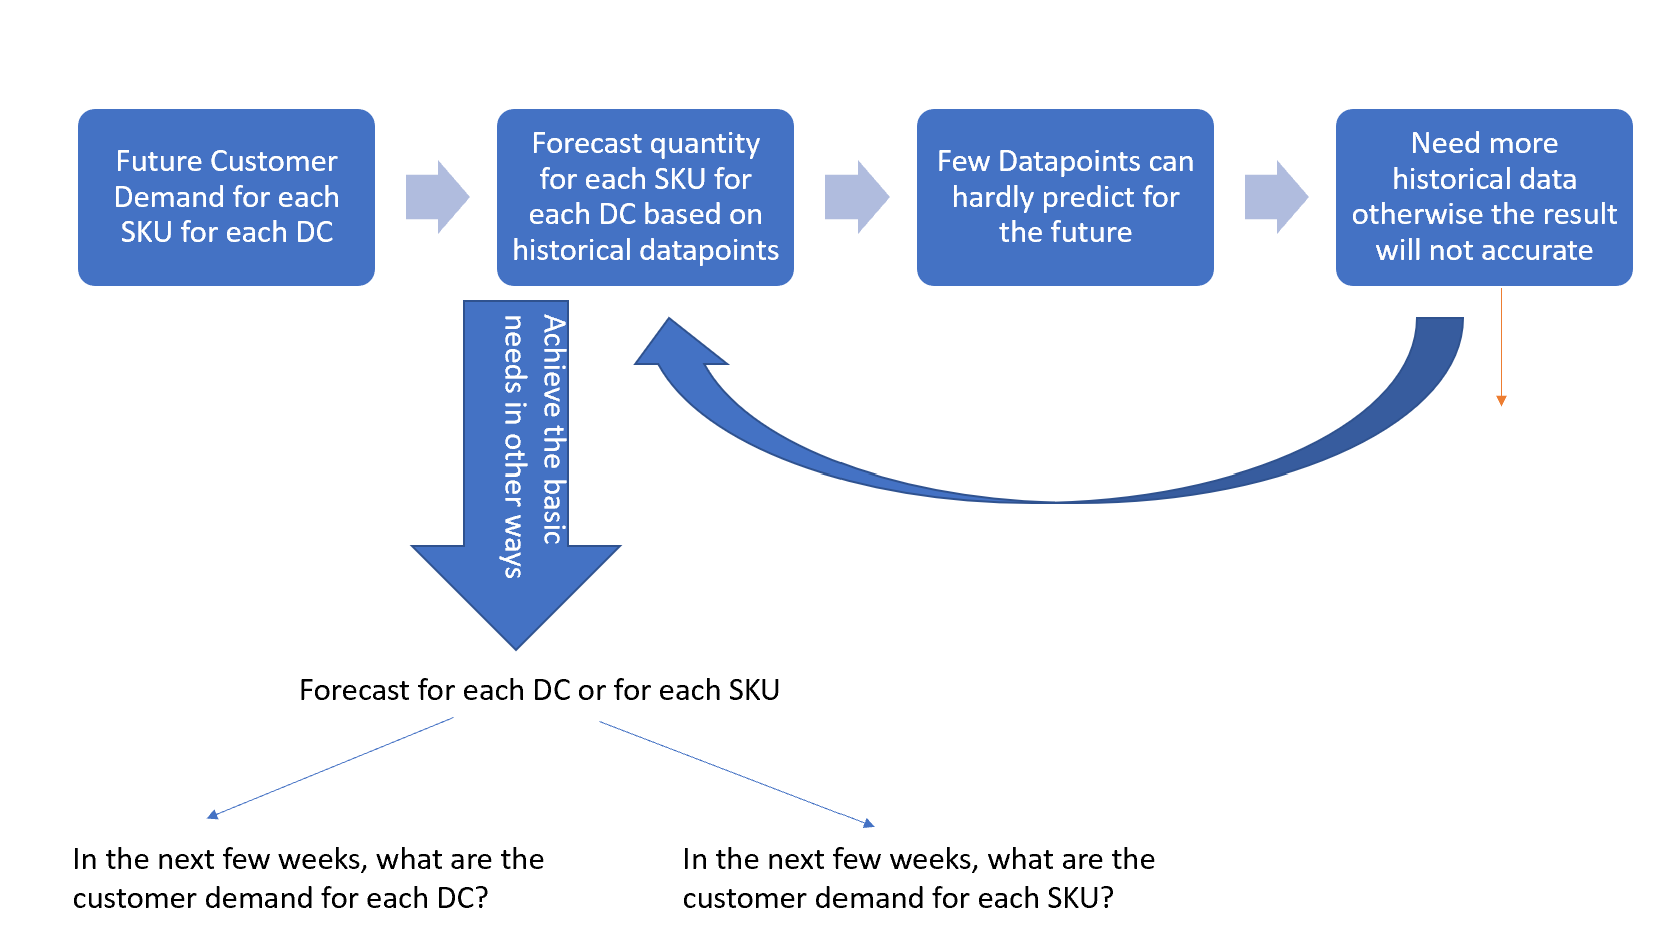

### Key Obj:
<ol>
<li type="A"> Understand Royal Canin’s current product demand by reviewing and analysing their customer demand data. The team will utilize historical demand to forecast future customer demand.</li>

<b>here we find for each dc, the datapoints of each sku are few</b>

<p> What variables we can use now?
  <ul>
    <li>Order Date (d)</li>
    <li>Order Quantity</li>
  </ul>
</p>
<p> 
 What we need?
 <ul>
    <li>volume</li>
    <li>price</li>
    <li>safety stock</li>
 </ul>
</p>

<b>
If we want to predict the demand for future date without other variables/factors to indicate, we should use time-series analytics
<span>
<ul>
<li>classical method: ARIMA (use time lag to do forecasting); 
<a href = "https://www.machinelearningplus.com/time-series/time-series-analysis-python/">relevant article</a></li>
  - we need to test stationarity for better forecasting results
<li>new tech: Deep Neural Network, like CNN & LSTM; <a href="https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_1_timeseries.ipynb">tutorial handout</a></li>
  - we can use more variables to perform
  - more accurate (in practical but hardly understand how does it work)
</ul>
</span>
</b>

<li type="A"> Identify the optimal inventory levels at each of Royal Canin’s 8 distribution centers for each of their SKUs by analyzing the relevant demand and supply chain data. The team will create recommendations for amount of safety stock held at the distribution centers to best meet the
demand for their customers.</li>

<strong>
if we want to find the optimal inventory, we can use non-linear programming optimization model
<ul>
<li>define an objective: e.g. max the profits / min the total cost</li>
<li>understand our decision variables: change the variables to meet the objective</li>
<li>find the best result: constraints / limitations</li>
</ul><br>
$$e.g. y = a + b * x_{1} + c * x_{2} + d * x_{3}$$ 
where: <br>
x1 <= c; <br>
x2 <= c; <br>
x3 >= c;
</strong>
<li type="A"> Share additional insights that can inform Royal Canin’s future distribution strategy, especially as they plan for future changes in their distribution network. </li>
</ol>

## Dataset 1
Data Preprocessing
- *notice:*
  1. null value
  2. combine **orlando** into **atlanta**, miami will be excluded
  3. date type

In [ ]:
import pandas as pd
import numpy as np
from dateutil.parser import parse
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

data=pd.read_excel(file, parse_dates=["Order Date"])
data.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,Order Date,Order Quantity,Stock Unit of Measure,Product SKU,Primary Warehouse,Primary Warehouse Zip Postal Code
0,2019-12-30,3.0,EA,563305,ASC- ORLANDO,32809.0
1,2019-12-30,2.0,EA,760217,ASC- FIFE,98424.0
2,2019-12-30,1.0,EA,664003,ASC- ORLANDO,32809.0
3,2019-12-30,2.0,EA,771513,ASC- ORLANDO,32809.0
4,2019-12-30,2.0,EA,472177,ASC- ORLANDO,32809.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data["Order Date"]=pd.to_datetime(data['Order Date'], format='%Y-%m-%d')
data["week"]=data["Order Date"].dt.week
data["year"]=data["Order Date"].dt.year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


some primary warehouse will not be considered

In [ ]:
data['Primary Warehouse'].unique() 

array(['ASC- ORLANDO', 'ASC- FIFE', 'ASC- WHITTIER', 'ASC- STOCKTON',
       'ASC - BARTLETT', 'ASC- ORRVILLE', 'ASC- ATLANTA', 'ASC- MONROE',
       'ASC- SCHERTZ', 'ASC- DENVER', 'Elite Printing and Packaging',
       'THE ISLANDER GROUP', 'PCA', 'Order Management Warehouse',
       'DB Schenker', 'POS Fulfillment Center'], dtype=object)

In [ ]:
DC = ['ASC- ORLANDO', 'ASC- FIFE', 'ASC- WHITTIER', 'ASC- STOCKTON',
      'ASC - BARTLETT', 'ASC- ORRVILLE', 'ASC- ATLANTA', 'ASC- MONROE',
       'ASC- SCHERTZ', 'ASC- DENVER']
select = data["Primary Warehouse"].apply(lambda x: x in DC)

In [ ]:
part_data = data[select]
dt = part_data.groupby(["Primary Warehouse","Product SKU","year","week"])["Order Quantity"].agg("sum")
dt

Primary Warehouse  Product SKU  year  week
ASC - BARTLETT     111103       2019  1        3.0
                                2020  16       3.0
                                      37       3.0
                                2021  1        3.0
                                      20       7.0
                                              ... 
ASC- WHITTIER      800075       2022  2       12.0
                                      4       35.0
                   843507       2020  8        1.0
                                      38       1.0
                                2022  5        1.0
Name: Order Quantity, Length: 51735, dtype: float64

In [ ]:
sku_rank = part_data.groupby(["Primary Warehouse","Product SKU"])["Stock Unit of Measure"].agg("count")
sku_rank = sku_rank.reset_index()
sku_rank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4442 entries, 0 to 4441
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Primary Warehouse      4442 non-null   object
 1   Product SKU            4442 non-null   object
 2   Stock Unit of Measure  4442 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 104.2+ KB


visualize skus' rank for each dc

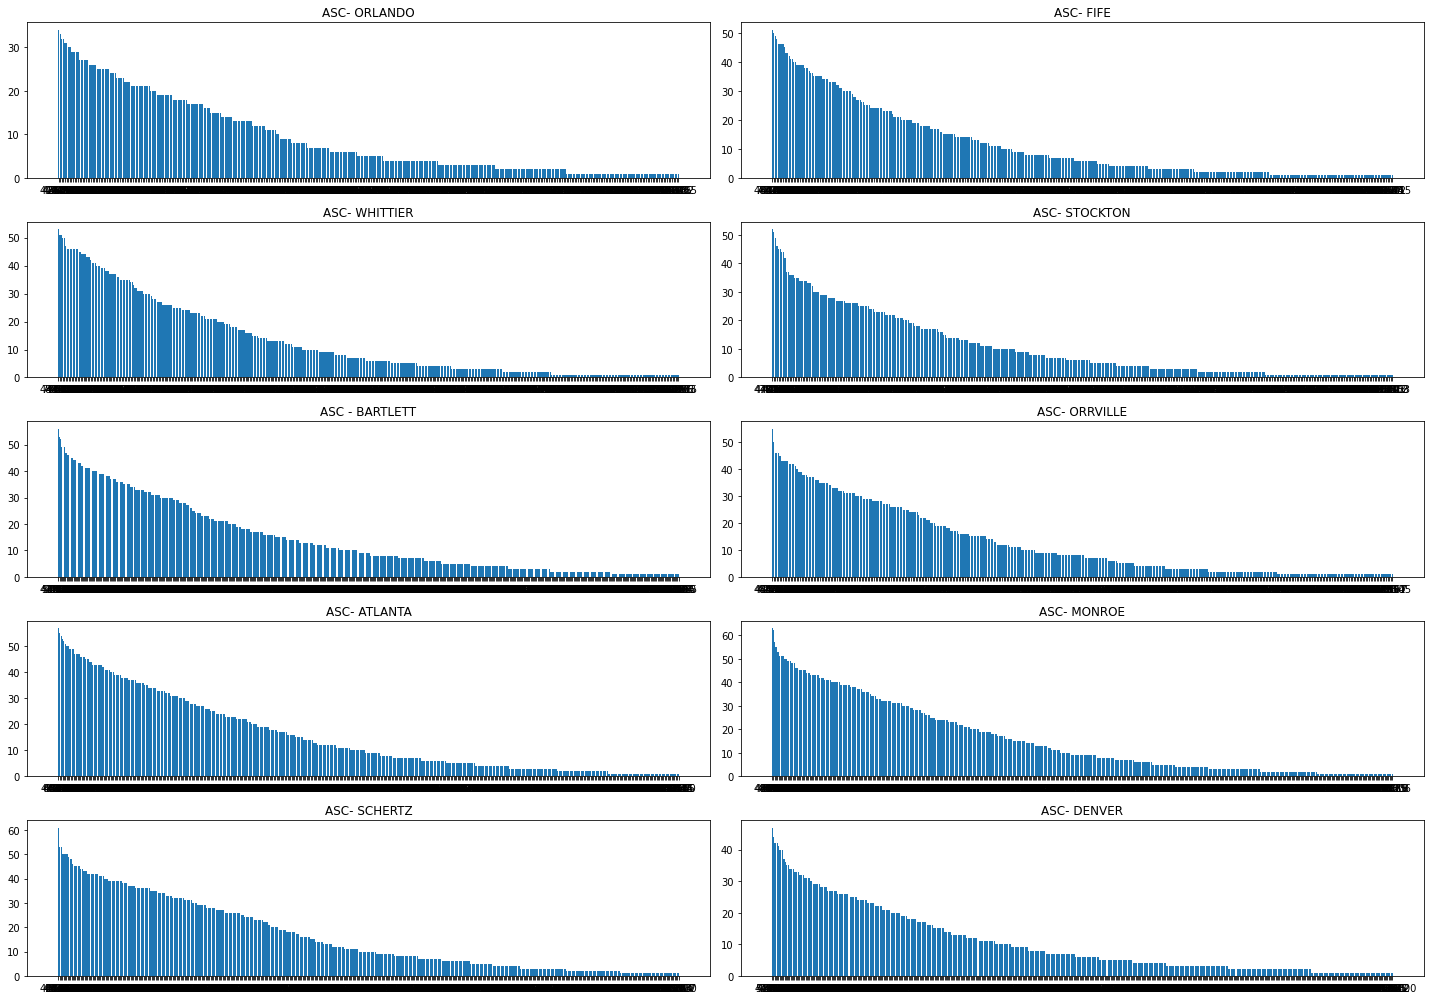

In [ ]:
fig, axes = plt.subplots(5,2, figsize=(20,14))

for i in range(len(DC)):
  dtst = sku_rank[sku_rank["Primary Warehouse"]==DC[i]]
  srt_dt = dtst.sort_values(by="Stock Unit of Measure",ascending=False)
  col = i%2
  row = i//2
  axes[row, col].set_title(DC[i])
  axes[row, col].bar(srt_dt["Product SKU"], srt_dt["Stock Unit of Measure"], tick_label=None)

plt.tight_layout()
plt.show()

In [ ]:
sku_rank[sku_rank["Primary Warehouse"]==DC[0]].sort_values(by="Stock Unit of Measure",ascending=False)

,Primary Warehouse,Product SKU,Stock Unit of Measure
2508,ASC- ORLANDO,470777,34
2527,ASC- ORLANDO,476888,33
2562,ASC- ORLANDO,488277,32
2436,ASC- ORLANDO,427677,32
2387,ASC- ORLANDO,260205,31
...,...,...,...
2569,ASC- ORLANDO,492306,1
2578,ASC- ORLANDO,494105,1
2579,ASC- ORLANDO,494132,1
2408,ASC- ORLANDO,41675,1


In [ ]:
len(data[(data["Product SKU"]=='470777')&(data["Primary Warehouse"]=='ASC- ORLANDO')])

34

if we try to select sku for each warehouse, we then obtain few data points

In [ ]:
len(data[(data["Product SKU"]=='470777')])

477

In [ ]:
len(data[data["Primary Warehouse"]=='ASC- ORLANDO'])

3481

<strong>How about we predict demands for each DC or each SKU in all DCs</strong>

**cv: use the dataset to compute the value of "cv"**

after having cv, we rank the dataset based on the value of cv

In [ ]:
def cv(dataset):
  id = list()
  std_li = list()
  mean_li = list()
  cv_li = list()

  for idx in dataset.index:
    if idx[:2] not in id: id.append(idx[:2])
  
  for idx in id:
    std_li.append(dt[idx].std())
    mean_li.append(dt[idx].mean())
    cv_li.append(dt[idx].std()/dt[idx].mean())

  result = pd.DataFrame({
      "idx":id,
      "std":std_li,
      "mean":mean_li,
      "cv":cv_li
  })
  return result

In [ ]:
sd_sku = cv(dt)

In [ ]:
sort_sku = sd_sku.sort_values(by="cv",ascending=False,na_position="last")
sort_sku

,idx,std,mean,cv
3241,"(ASC- SCHERTZ, 426066)",44015.828059,7511.971429,5.859424
1257,"(ASC- DENVER, 493805)",14.162324,7.000000,2.023189
1913,"(ASC- MONROE, 245118)",46.848775,23.846154,1.964626
2133,"(ASC- MONROE, 484317)",132.110705,72.289474,1.827523
3941,"(ASC- STOCKTON, 583012)",15.117988,8.375000,1.805133
...,...,...,...,...
4397,"(ASC- WHITTIER, 60433)",NaN,1.000000,NaN
4403,"(ASC- WHITTIER, 62216)",NaN,1.000000,NaN
4412,"(ASC- WHITTIER, 630310)",NaN,2.000000,NaN
4413,"(ASC- WHITTIER, 646074)",NaN,2.000000,NaN


In [ ]:
sort_sku.dropna(subset=["cv"],inplace=True)
sort_sku.reset_index(inplace=True,drop=True)

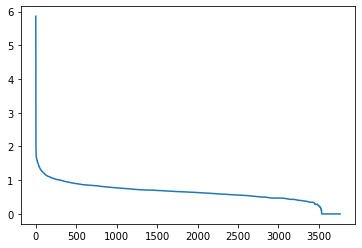

In [ ]:
sort_sku["cv"].plot()

**We find the cv of skus are bounded in 0 to 15%**

In [ ]:
sort_sku[sort_sku["cv"]<=0.15].shape # there are 3230 skus

(236, 4)

In [ ]:
sort_sku[sort_sku["cv"]<=0.15]

,idx,std,mean,cv
3529,"(ASC- ORLANDO, 428277)",0.577350,4.666667,0.123718
3530,"(ASC- FIFE, 164080)",0.577350,5.333333,0.108253
3531,"(ASC - BARTLETT, 417866)",0.577350,5.333333,0.108253
3532,"(ASC - BARTLETT, M451138)",0.707107,7.500000,0.094281
3533,"(ASC- DENVER, 174920)",1.414214,15.000000,0.094281
...,...,...,...,...
3760,"(ASC- ORLANDO, 175010)",0.000000,1.000000,0.000000
3761,"(ASC- ORLANDO, 174960)",0.000000,1.000000,0.000000
3762,"(ASC- MONROE, 626044)",0.000000,1.000000,0.000000
3763,"(ASC- MONROE, 584207)",0.000000,1.000000,0.000000


In [ ]:
sort_sku[(sort_sku["cv"]<=0.15) & (sort_sku["cv"] > 0)]["idx"]

3529       (ASC- ORLANDO, 428277)
3530          (ASC- FIFE, 164080)
3531     (ASC - BARTLETT, 417866)
3532    (ASC - BARTLETT, M451138)
3533        (ASC- DENVER, 174920)
3534     (ASC - BARTLETT, 510810)
Name: idx, dtype: object

In [ ]:
data[(data["Product SKU"]=='175010')&(data["Primary Warehouse"]=='ASC- ORLANDO')]

,Order Date,Order Quantity,Stock Unit of Measure,Product SKU,Primary Warehouse,Primary Warehouse Zip Postal Code,week,year
10410,2020-04-25,1.0,EA,175010,ASC- ORLANDO,32809.0,17,2020
18508,2020-07-31,1.0,EA,175010,ASC- ORLANDO,32809.0,31,2020
30470,2020-12-10,1.0,EA,175010,ASC- ORLANDO,32809.0,50,2020


In [ ]:
# Combine Denver Case to test stationarity for 10 DCs 
# for non-stationary data, we should jump to differencing part
# def test_stationarity(dataset):
from statsmodels.tsa.stattools import adfuller

def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

for i in range(len(DC)):
  dtst = data[data["Primary Warehouse"] == DC[i]]
  dtst = dtst.groupby(["Order Date"])["Order Quantity"].agg("sum")
  dtst = dtst.reset_index()
  dtst.set_index("Order Date", inplace=True)
  dtst = dtst.asfreq(freq='d',fill_value=0)
  result = adfuller(dtst["Order Quantity"])
  print("===========%s============" %(DC[i]))
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))
  print("========= entropy =========")
  print("ApEn:")
  print(ApEn(dtst["Order Quantity"].tolist(), m=2, r=0.2*np.std(dtst["Order Quantity"].tolist())))
  print("SampEn:")
  print(SampEn(dtst["Order Quantity"].tolist(), m=2, r=0.2*np.std(dtst["Order Quantity"].tolist())))

===========ASC- ORLANDO============
ADF Statistic: -4.593677
p-value: 0.000133
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570
========= entropy =========
ApEn:
1.3279757695180758
SampEn:
1.5488928208590818
===========ASC- FIFE============
ADF Statistic: -2.508392
p-value: 0.113446
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
========= entropy =========
ApEn:
1.501183897573274
SampEn:
1.626810162158571
===========ASC- WHITTIER============
ADF Statistic: -3.142155
p-value: 0.023587
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
========= entropy =========
ApEn:
1.462342179932787
SampEn:
1.6805222591729563
===========ASC- STOCKTON============
ADF Statistic: -4.234751
p-value: 0.000575
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
========= entropy =========
ApEn:
1.4773163063315522
SampEn:
1.6800101307751656
===========ASC - BARTLETT============
ADF Statistic: -4.423387
p-value: 0.000270
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
========= entropy

ASC- ORLANDO: 0.000575 <br>
<b>ASC- FIFE: 0.11 </b> <br>
ASC- WHITTIER: 0.02 <br>
ASC- STOCKTON: 0.000575 <br>
ASC - BARTLETT: 0.000270 <br>
ASC- ORRVILLE: 0.011215 <br>
ASC- ATLANTA: 0.011381 <br>
ASC- MONROE: 0.000100 <br>
ASC- SCHERTZ:0.000000 <br>
<b>ASC- DENVER:0.265516</b> <br>



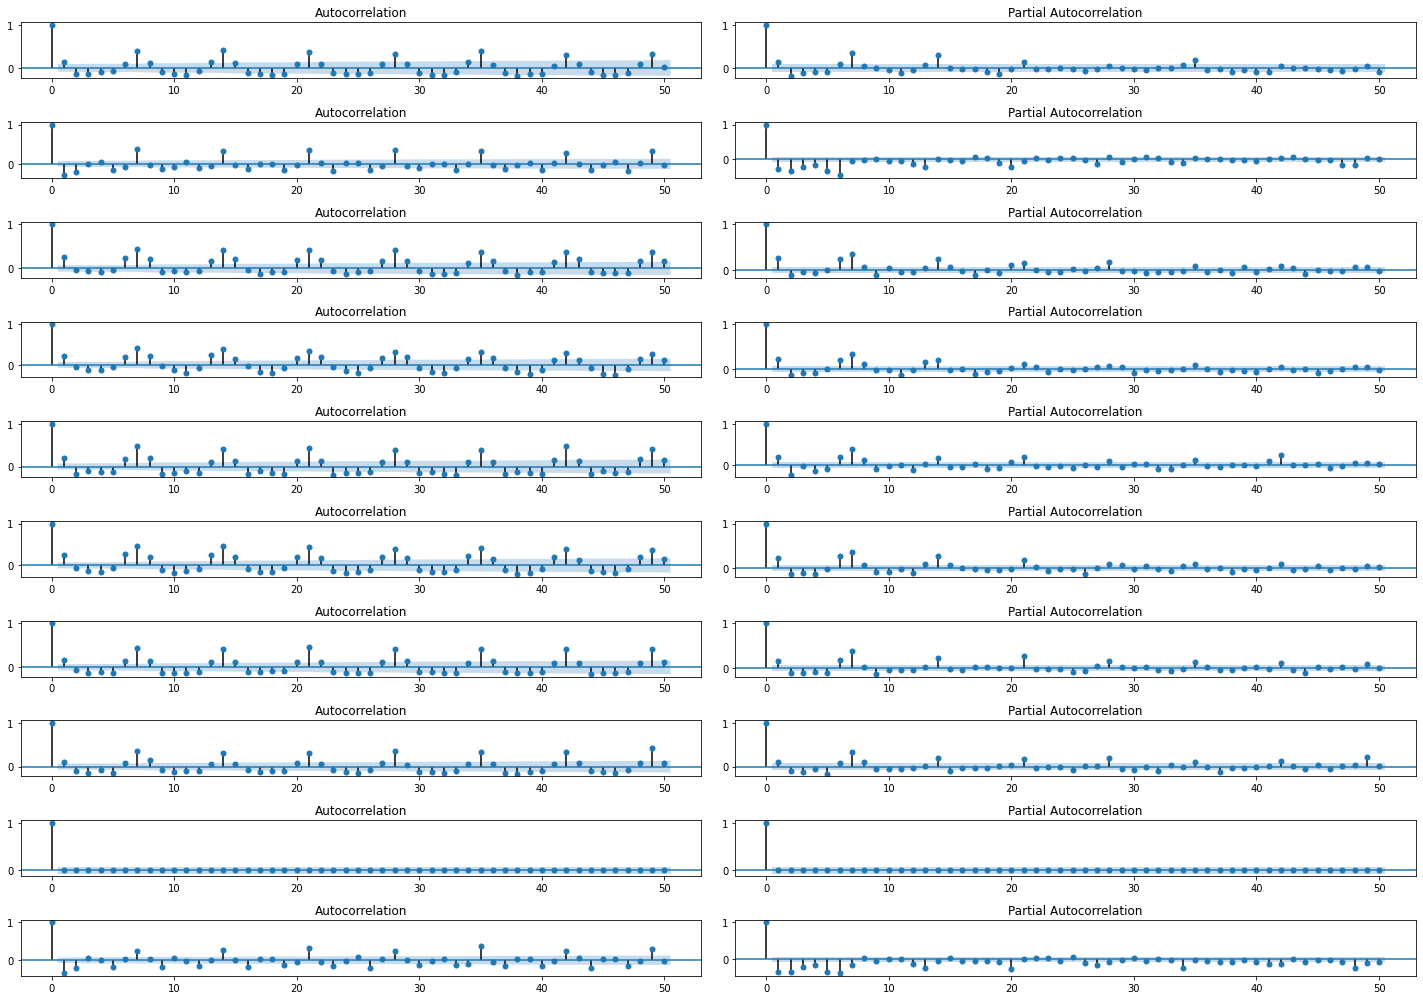

In [ ]:
fig, axes = plt.subplots(10,2, figsize=(20,14))
for i in range(len(DC)):
  dtst = data[data["Primary Warehouse"] == DC[i]]
  # daily
  dtst = dtst.groupby(["Order Date"])["Order Quantity"].agg("sum")
  dtst = dtst.reset_index()
  dtst.set_index("Order Date", inplace=True)
  dtst = dtst.asfreq(freq='d',fill_value=0)

  axes[i, 0].set_title(DC[i])
  if DC[i]=="ASC- FIFE" or DC[i]=="ASC- DENVER":
    plot_acf(dtst["Order Quantity"].diff().dropna(),lags=50,ax=axes[i,0]) # MA (window q): 2 or 3
    plot_pacf(dtst["Order Quantity"].diff().dropna(),lags=50,ax=axes[i,1])  # p: 1
  else:
    plot_acf(dtst["Order Quantity"],lags=50,ax=axes[i,0]) # MA (window q): 2 or 3
    plot_pacf(dtst["Order Quantity"],lags=50,ax=axes[i,1])  # p: 1

plt.tight_layout()
plt.show()

Example: Denver

In [ ]:
# data[(data["Primary Warehouse"]=="ASC- DENVER")&(data["Product SKU"]=="20834000")] # for each sku, the number is so few, hard to make a model
denver = data[(data["Primary Warehouse"]=="ASC- DENVER")] # we can forecast the warehouse's order (this is feasible), or whole sku (but still small dataset)

In [ ]:
denver.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5242 entries, 31 to 63975
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Order Date                         5242 non-null   datetime64[ns]
 1   Order Quantity                     5242 non-null   float64       
 2   Stock Unit of Measure              5242 non-null   object        
 3   Product SKU                        5242 non-null   object        
 4   Primary Warehouse                  5242 non-null   object        
 5   Primary Warehouse Zip Postal Code  5242 non-null   float64       
 6   week                               5242 non-null   int64         
 7   year                               5242 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 368.6+ KB


In [ ]:
dg = denver.groupby(["year","week"])["Order Quantity"].agg("sum")

In [ ]:
dg = dg.reset_index()

In [ ]:
dg['date'] = dg['year'].astype("string")+"-"+dg['week'].astype("string")

In [ ]:
dg["date"].astype("object")

0       2019-1
1       2020-1
2       2020-2
3       2020-3
4       2020-4
        ...   
108     2022-2
109     2022-3
110     2022-4
111     2022-5
112    2022-52
Name: date, Length: 113, dtype: object

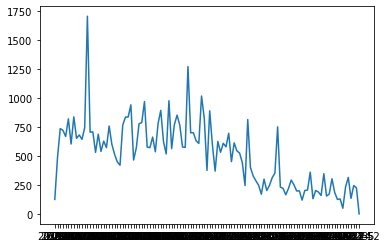

In [ ]:
plt.plot(dg["date"].astype("object"),dg['Order Quantity'])
plt.show()

**Decompose a time series into components: base, trend, seasonal, and errors**

In [ ]:
dvr = denver.groupby(["Order Date"])["Order Quantity"].agg("sum")
dvr = dvr.reset_index()

In [ ]:
dvr.set_index("Order Date", inplace=True)

In [ ]:
dvr = dvr.asfreq(freq='d',fill_value=0)

In [ ]:
dvr.index[-1]-dvr.index[0]

Timedelta('764 days 00:00:00')

In [ ]:
dvr.index

DatetimeIndex(['2019-12-31', '2020-01-01', '2020-01-02', '2020-01-03',
               '2020-01-04', '2020-01-05', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09',
               ...
               '2022-01-24', '2022-01-25', '2022-01-26', '2022-01-27',
               '2022-01-28', '2022-01-29', '2022-01-30', '2022-01-31',
               '2022-02-01', '2022-02-02'],
              dtype='datetime64[ns]', name='Order Date', length=765, freq='D')

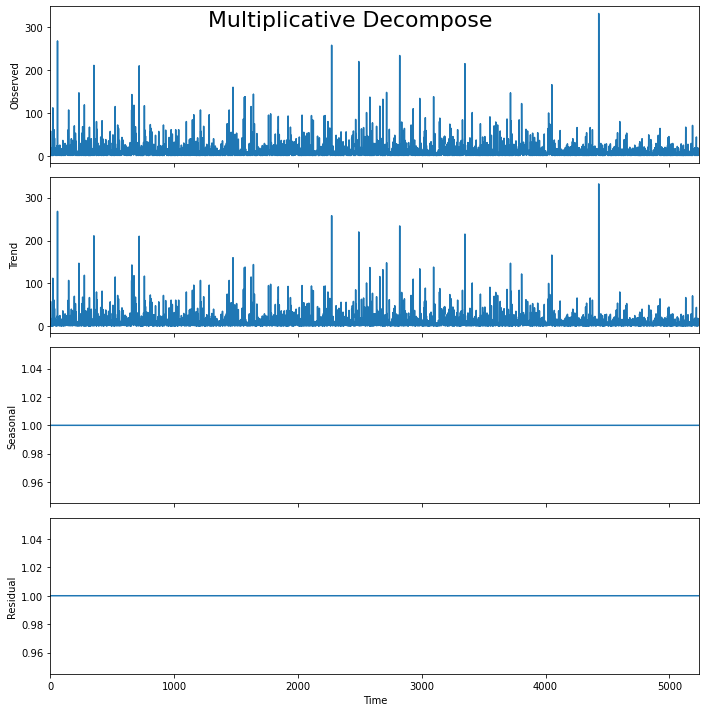

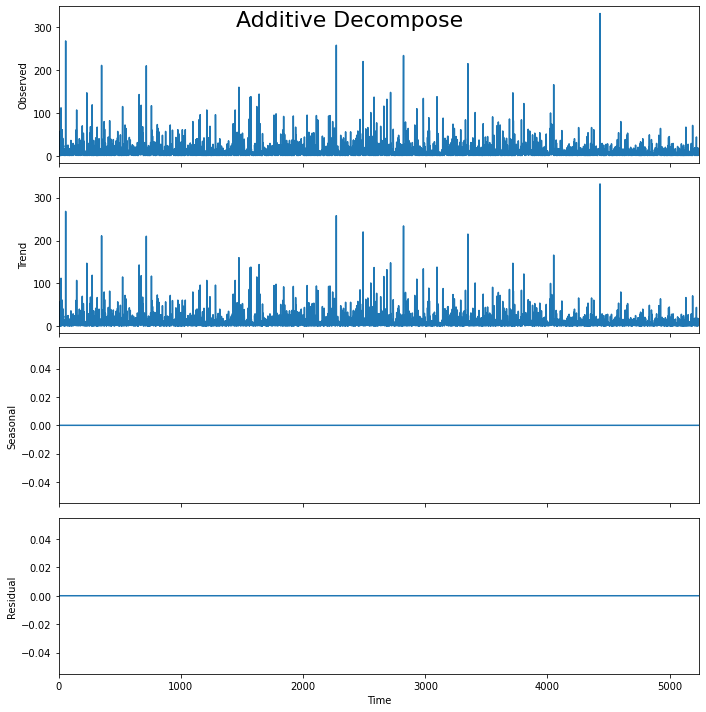

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative Decomposition 
result_mul = seasonal_decompose(denver["Order Quantity"].values, model='multiplicative', extrapolate_trend='freq', freq=1)

# Additive Decomposition
result_add = seasonal_decompose(denver["Order Quantity"].values, model='additive', extrapolate_trend='freq', freq=1)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

## **Time Series Forecasting Model**
* [important article](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)

### Test Stationarity

In [ ]:
dvr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 765 entries, 2019-12-31 to 2022-02-02
Freq: D
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order Quantity  765 non-null    float64
dtypes: float64(1)
memory usage: 12.0 KB


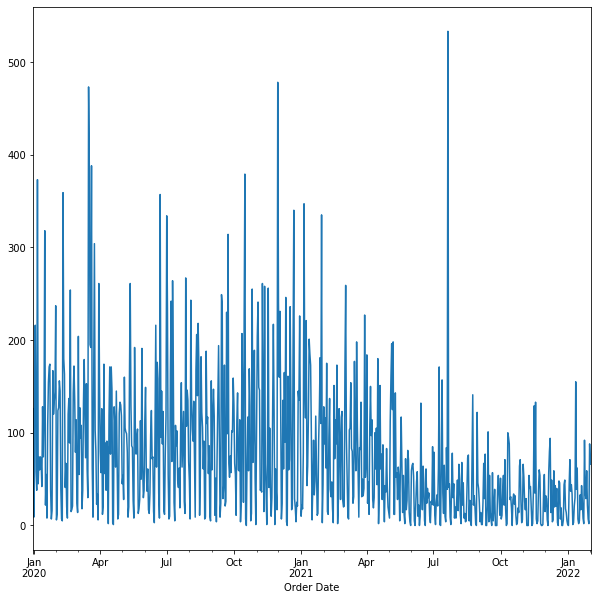

In [ ]:
plt.figure(figsize=(10,10))
dvr["Order Quantity"].plot()

**Test for seasonality**

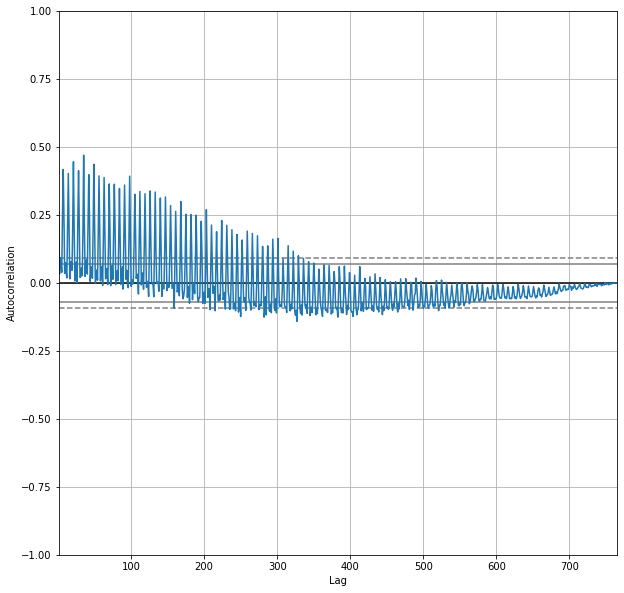

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(dvr['Order Quantity'].tolist())

**We need to test the stationarity (trend or seasonality) before forecasting**
- If we want to use classical model, like AR, MA, ARMA, ARIMA, we need stationary data

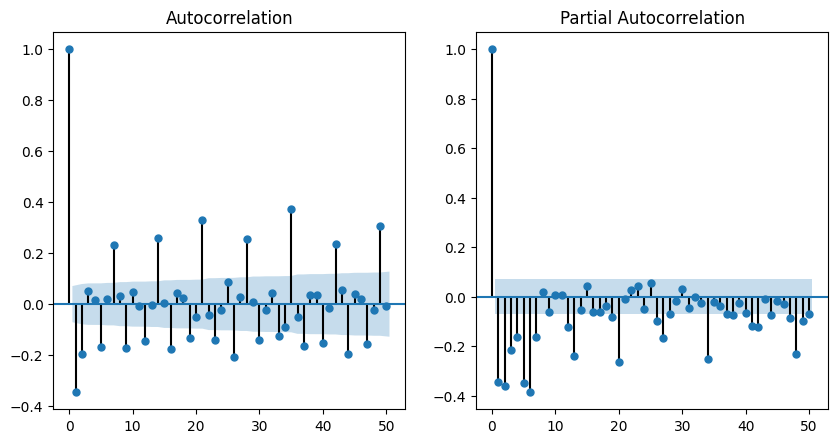

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1,2,figsize=(10,5),dpi=100)
plot_acf(dvr["Order Quantity"].diff().dropna(),lags=50,ax=axes[0]) # MA (window q): 2 or 3
plot_pacf(dvr["Order Quantity"].diff().dropna(),lags=50,ax=axes[1])  # p: 1
plt.show()

In [ ]:
def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

print(ApEn(dvr["Order Quantity"].tolist(), m=2, r=0.2*np.std(dvr["Order Quantity"].tolist())))     # 1.41 very difficult to predict

1.4102890887176827


In [ ]:
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

print(SampEn(dvr["Order Quantity"].tolist(), m=2, r=0.2*np.std(dvr["Order Quantity"].tolist())))       # 1.50

1.5037688296274105


In [ ]:
dvr2 = dvr.reset_index()

In [ ]:
dvr2

,Order Date,Order Quantity
0,2019-12-31,126.0
1,2020-01-01,9.0
2,2020-01-02,167.0
3,2020-01-03,216.0
4,2020-01-04,58.0
...,...,...
760,2022-01-29,7.0
761,2022-01-30,2.0
762,2022-01-31,88.0
763,2022-02-01,66.0


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
dvr2['month'] = dvr2["Order Date"].dt.month
grangercausalitytests(dvr2[["Order Quantity", 'month']], maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1326  , p=0.0135  , df_denom=761, df_num=1
ssr based chi2 test:   chi2=6.1568  , p=0.0131  , df=1
likelihood ratio test: chi2=6.1321  , p=0.0133  , df=1
parameter F test:         F=6.1326  , p=0.0135  , df_denom=761, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1506  , p=0.0434  , df_denom=758, df_num=2
ssr based chi2 test:   chi2=6.3428  , p=0.0419  , df=2
likelihood ratio test: chi2=6.3166  , p=0.0425  , df=2
parameter F test:         F=3.1506  , p=0.0434  , df_denom=758, df_num=2


{1: ({'lrtest': (6.132127379802114, 0.013274704652843274, 1),
   'params_ftest': (6.13262671057264, 0.01348732579572357, 761.0, 1.0),
   'ssr_chi2test': (6.156802637158175, 0.013090763050546054, 1),
   'ssr_ftest': (6.132626710572475, 0.013487325795723667, 761.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (6.316598580880964, 0.04249795633511723, 2),
   'params_ftest': (3.1506261506066036, 0.043386684110190574, 758.0, 2.0),
   'ssr_chi2test': (6.342817290007507, 0.04194447139902366, 2),
   'ssr_ftest': (3.150626150606612, 0.043386684110190574, 758.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

In [ ]:
dvr2['wk'] = dvr2["Order Date"].dt.week
grangercausalitytests(dvr2[["Order Quantity", 'wk']], maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7647  , p=0.0166  , df_denom=761, df_num=1
ssr based chi2 test:   chi2=5.7874  , p=0.0161  , df=1
likelihood ratio test: chi2=5.7656  , p=0.0163  , df=1
parameter F test:         F=5.7647  , p=0.0166  , df_denom=761, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3338  , p=0.0050  , df_denom=758, df_num=2
ssr based chi2 test:   chi2=10.7379 , p=0.0047  , df=2
likelihood ratio test: chi2=10.6630 , p=0.0048  , df=2
parameter F test:         F=5.3338  , p=0.0050  , df_denom=758, df_num=2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


{1: ({'lrtest': (5.7655758324799535, 0.01634312847342617, 1),
   'params_ftest': (5.764660471525656, 0.01659066402865358, 761.0, 1.0),
   'ssr_chi2test': (5.787385808469853, 0.016141575224420463, 1),
   'ssr_ftest': (5.7646604715256, 0.01659066402865358, 761.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (10.663045995113862, 0.00483669812056616, 2),
   'params_ftest': (5.33376842182163, 0.00500866883337837, 758.0, 2.0),
   'ssr_chi2test': (10.737903181662016, 0.004659013302938423, 2),
   'ssr_ftest': (5.333768421821631, 0.00500866883337837, 758.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(dvr["Order Quantity"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.048984
p-value: 0.265516
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [ ]:
result = adfuller(dvr["Order Quantity"].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.453131
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [ ]:
result = adfuller(dvr["Order Quantity"].diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -13.433887
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


**we can see the p-value is higher than 0.05, so it is insignificant. So it is non-stationary, which means that we need use differencing method**

### Non-seasonal ARIMA Models
* [more details](https://otexts.com/fpp2/non-seasonal-arima.html)

In [ ]:
TRAIN = int(len(dvr)*0.95)

trainset = dvr.iloc[:TRAIN, :]
testset = dvr.iloc[TRAIN:, :]

In [ ]:
len(testset)

39

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# (1,1,1)
# ma.L2 and ar.L2 are significant

model1 =ARIMA(trainset, order=(2,1,2))
model_fit1 = model1.fit(disp=-1)
print(model_fit1.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.Order Quantity   No. Observations:                  725
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4123.295
Method:                       css-mle   S.D. of innovations             71.237
Date:                Thu, 10 Feb 2022   AIC                           8258.590
Time:                        03:09:11   BIC                           8286.108
Sample:                    01-01-2020   HQIC                          8269.210
                         - 12-25-2021                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.1205      0.059     -2.040      0.042      -0.236      -0.005
ar.L1.D.Order Quantity     0.5945      0.117      5.061      0.000       0.364       0.825
ar.L

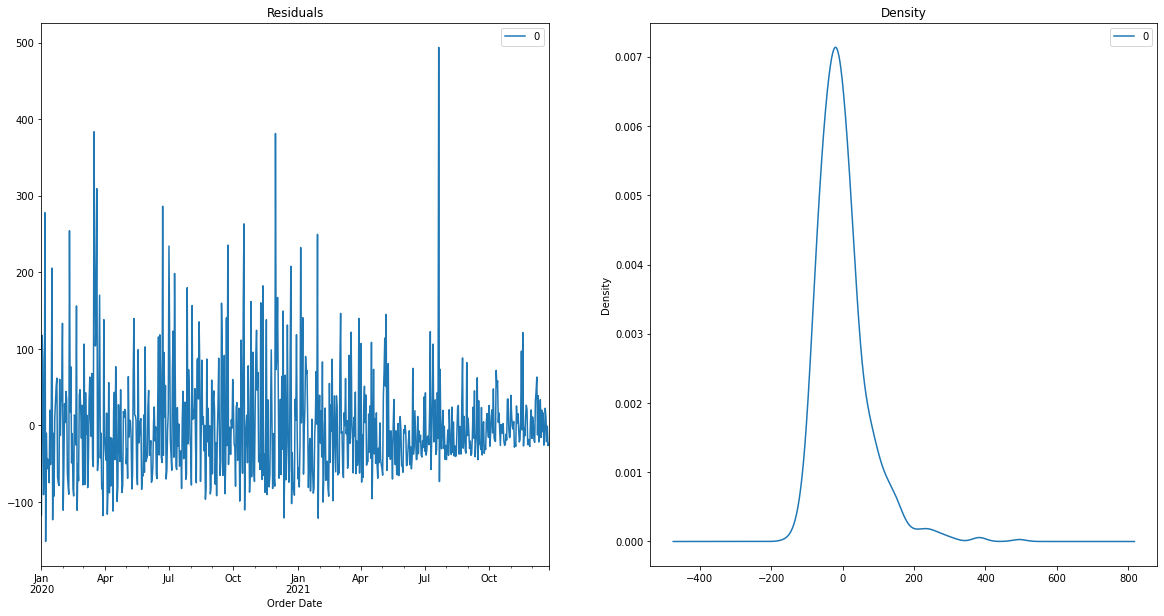

In [ ]:
from IPython.core.pylabtools import figsize
# Plot residual errors
residuals = pd.DataFrame(model_fit1.resid)
fig, ax = plt.subplots(1,2,figsize=(20,10))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density',ax=ax[1])
plt.show()

**Forecasting Part**

In [ ]:
STEPS=len(testset) # forecasting periods
CL = 0.05 # confidence level alpha 

In [ ]:
fc, se, conf = model_fit1.forecast(steps=STEPS, alpha=CL)
testset['predicted_orders'] = fc
testset['lower_predicted_orders'] = conf[:,0]
testset['higher_predicted_orders'] = conf[:,1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

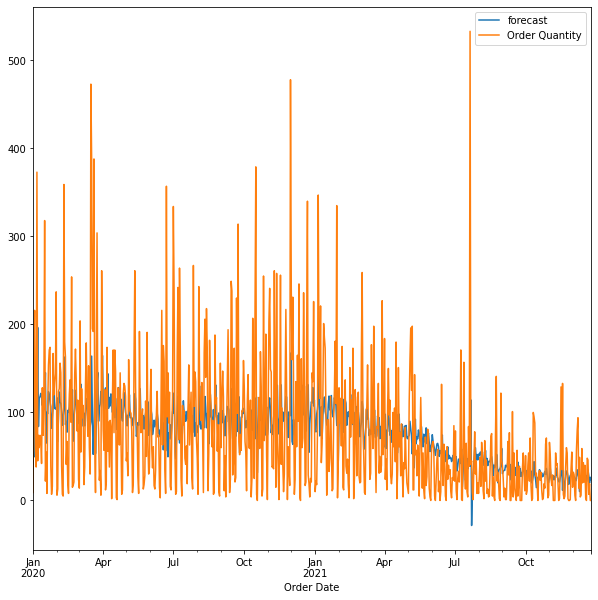

In [ ]:
model_fit1.plot_predict(dynamic=False)
plt.show()

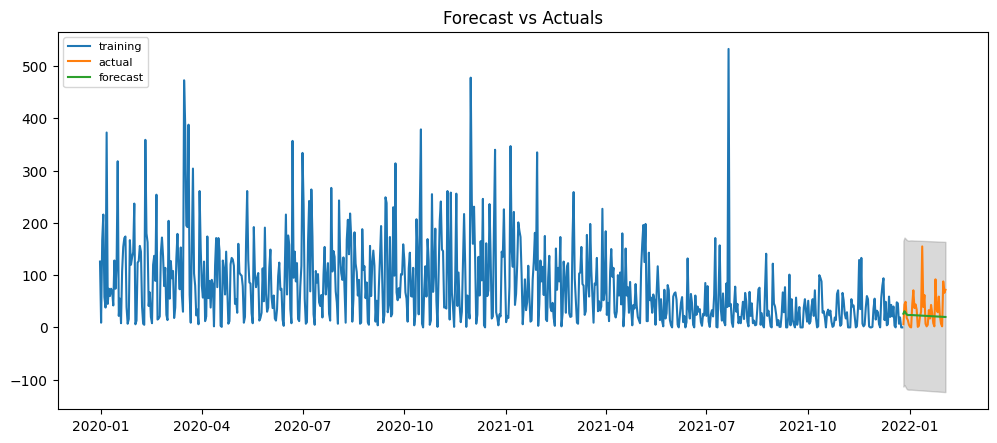

In [ ]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(trainset["Order Quantity"], label='training')
plt.plot(testset["Order Quantity"], label='actual')
plt.plot(testset["predicted_orders"], label='forecast')
plt.fill_between(testset.index, testset['lower_predicted_orders'], testset['higher_predicted_orders'], 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf
"""
Mean Absolute Percentage Error (MAPE)
Around 2.2% MAPE implies the model is about 97.8% accurate in predicting the next 15 observations.
Mean Error (ME)
Mean Absolute Error (MAE)
Mean Percentage Error (MPE)
Root Mean Squared Error (RMSE)
Lag 1 Autocorrelation of Error (ACF1)
Correlation between the Actual and the Forecast (corr)
Min-Max Error (minmax)
"""
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, testset["Order Quantity"].values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


{'acf1': 0.17676438209249082,
 'corr': -0.0879239744477847,
 'mae': 24.284591517670858,
 'mape': inf,
 'me': -10.655234689485,
 'minmax': 0.5737327138241598,
 'mpe': inf,
 'rmse': 34.03157443924987}

**differencing**

In [ ]:
dvr3 = dvr.reset_index()
dvr3

,Order Date,Order Quantity
0,2019-12-31,126.0
1,2020-01-01,9.0
2,2020-01-02,167.0
3,2020-01-03,216.0
4,2020-01-04,58.0
...,...,...
760,2022-01-29,7.0
761,2022-01-30,2.0
762,2022-01-31,88.0
763,2022-02-01,66.0


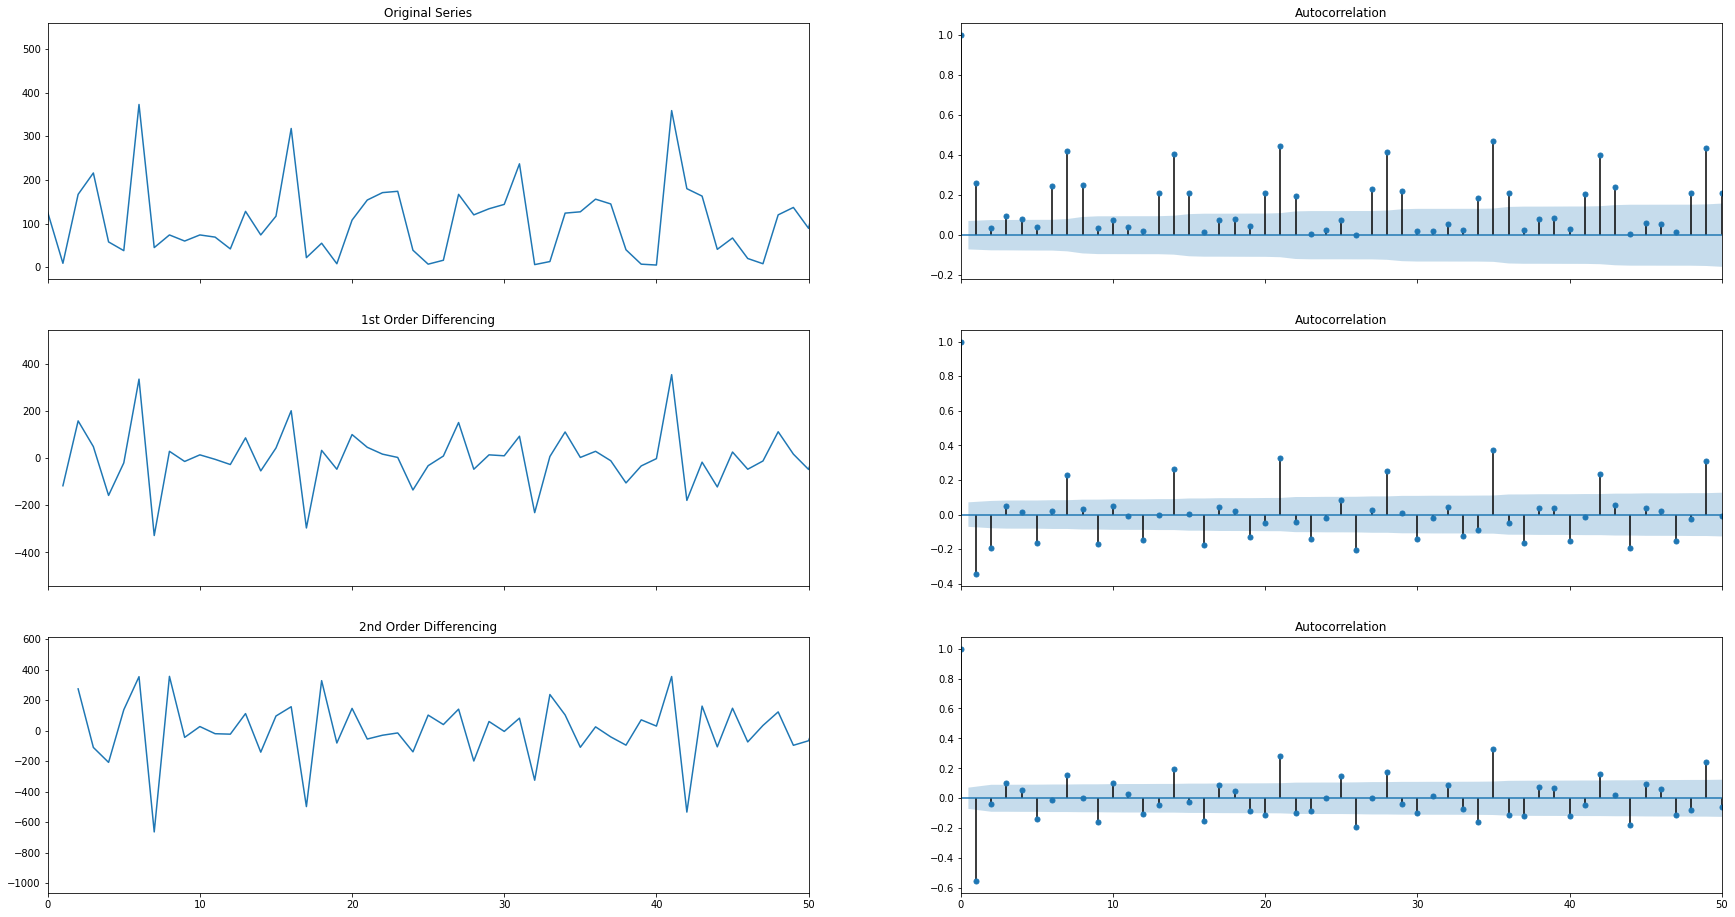

In [ ]:
fig, axes = plt.subplots(3, 2, sharex=True,figsize=(30,16))
axes[0, 0].plot(dvr3["Order Quantity"])
axes[0, 0].set_title('Original Series')
axes[0,1].set_xlim(0,50)
plot_acf(dvr3["Order Quantity"], ax=axes[0, 1], lags=50)

# 1st Differencing
axes[1, 0].plot(dvr3["Order Quantity"].diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(dvr3["Order Quantity"].diff().dropna(), ax=axes[1, 1], lags=50)

# 2nd Differencing
axes[2, 0].plot(dvr3["Order Quantity"].diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(dvr3["Order Quantity"].diff().diff().dropna(), ax=axes[2, 1], lags=50)

plt.show()

In [ ]:
model2 =ARIMA(trainset, order=(1,1,1))
model_fit2 = model2.fit(disp=0)
print(model_fit2.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:       D.Order Quantity   No. Observations:                 4716
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -20514.301
Method:                       css-mle   S.D. of innovations             18.735
Date:                Wed, 09 Feb 2022   AIC                          41036.601
Time:                        04:01:03   BIC                          41062.436
Sample:                             1   HQIC                         41045.683
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0007      0.001     -1.399      0.162      -0.002       0.000
ar.L1.D.Order Quantity     0.0957      0.015      6.585      0.000       0.067       0.124
ma.L

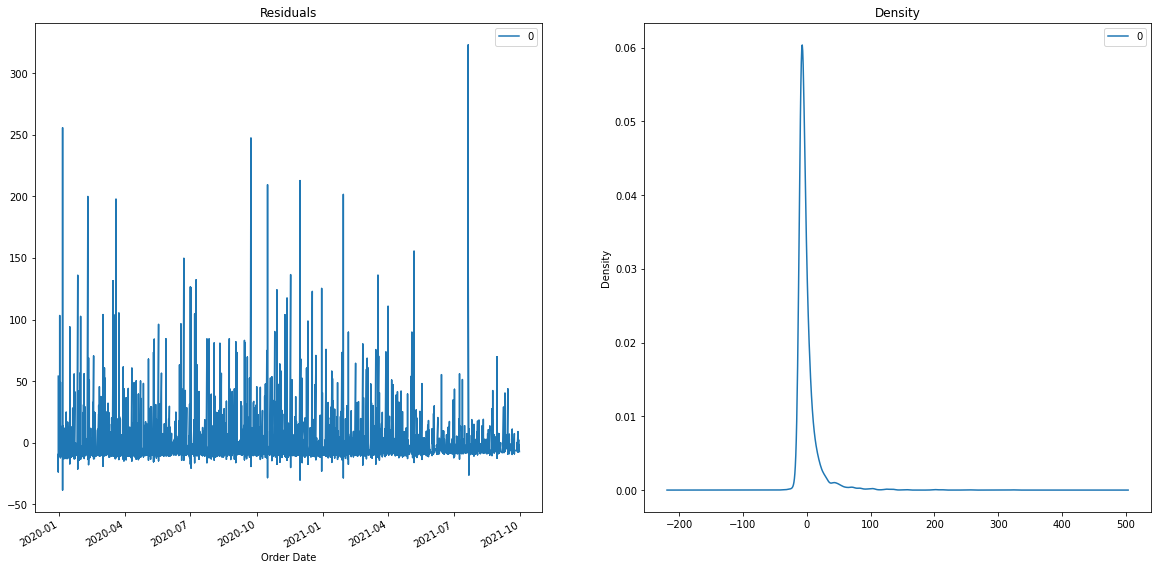

In [ ]:
residuals = pd.DataFrame(model_fit2.resid)
fig, ax = plt.subplots(1,2,figsize=(20,10))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density',ax=ax[1])
plt.show()

### Auto ARIMA Forecast

In [ ]:
# !pip install pmdarima //cannot install
# import pyramid.arima

  Using cached pmdarima-1.8.4-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.4 MB)
  Using cached statsmodels-0.13.2.tar.gz (17.9 MB)
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user


In [ ]:
# model = pm.auto_arima(dt["Order Quantity"], start_p=1, start_q=1,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=3, max_q=3, # maximum p and q
#                       m=1,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=False,   # No Seasonality
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True)

# print(model.summary())

### Neural Network (LSTM & CNN) 

In [ ]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

def build_model():
  model = Sequential()
  model.add(LSTM(256, dropout=0.0, recurrent_dropout=0.0,input_shape=(None, 1)))
  model.add(Dense(64))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

In [ ]:
from statsmodels.tsa.stattools import acf
"""
Mean Absolute Percentage Error (MAPE)
Around 2.2% MAPE implies the model is about 97.8% accurate in predicting the next 15 observations.
Mean Error (ME)
Mean Absolute Error (MAE)
Mean Percentage Error (MPE)
Root Mean Squared Error (RMSE)
Lag 1 Autocorrelation of Error (ACF1)
Correlation between the Actual and the Forecast (corr)
Min-Max Error (minmax)
"""
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [ ]:
def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-SEQUENCE_SIZE):
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

DC = ['ASC- ORLANDO', 'ASC- FIFE', 'ASC- WHITTIER', 'ASC- STOCKTON',
      'ASC - BARTLETT', 'ASC- ORRVILLE', 'ASC- ATLANTA', 'ASC- MONROE',
       'ASC- SCHERTZ', 'ASC- DENVER']

SEQUENCE_SIZE = 50
result_printout = []
for i in range(len(DC)):
  dtst = data[data["Primary Warehouse"] == DC[i]]
  # daily
  dtst = dtst.groupby(["Order Date"])["Order Quantity"].agg("sum")
  dtst = dtst.reset_index()
  dtst.set_index("Order Date", inplace=True)
  dtst = dtst.asfreq(freq='d',fill_value=0)
  
  TRAIN = int(len(dtst)*0.80)
  trainset = dtst.iloc[:TRAIN, :]
  testset = dtst.iloc[TRAIN:, :]

  order_train = trainset['Order Quantity'].tolist()
  order_test = testset['Order Quantity'].tolist()

  x_train,y_train = to_sequences(SEQUENCE_SIZE,order_train)
  x_test,y_test = to_sequences(SEQUENCE_SIZE,order_test)

  print("Shape of training set: {}".format(x_train.shape))
  print("Shape of test set: {}".format(x_test.shape))

  model = build_model()
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
                        verbose=1, mode='auto', restore_best_weights=True)
  model.fit(x_train,y_train,validation_data=(x_test,y_test),
            callbacks=[monitor],verbose=2,epochs=100)
  
  pred = model.predict(x_test)
  resp_pred = pred.reshape(-1,)

  result_printout.append(forecast_accuracy(resp_pred,y_test))

Shape of training set: (328, 50, 1)
Shape of test set: (45, 50, 1)
Epoch 1/100
11/11 - 4s - loss: 29330.7676 - val_loss: 36676.8789 - 4s/epoch - 389ms/step
Epoch 2/100
11/11 - 2s - loss: 25745.4395 - val_loss: 31421.5273 - 2s/epoch - 145ms/step
Epoch 3/100
11/11 - 2s - loss: 21608.3477 - val_loss: 25519.2031 - 2s/epoch - 144ms/step
Epoch 4/100


KeyboardInterrupt: ignored

Shape of training set: (328, 50, 1)
Shape of test set: (45, 50, 1)
Epoch 1/100
11/11 - 5s - loss: 29280.9824 - val_loss: 36137.0195 - 5s/epoch - 481ms/step
Epoch 2/100
11/11 - 2s - loss: 24935.5332 - val_loss: 30097.0918 - 2s/epoch - 151ms/step
Epoch 3/100
11/11 - 2s - loss: 20093.2188 - val_loss: 24066.0586 - 2s/epoch - 151ms/step
Epoch 4/100
11/11 - 2s - loss: 17176.9043 - val_loss: 20855.4453 - 2s/epoch - 150ms/step
Epoch 5/100
11/11 - 2s - loss: 16884.8594 - val_loss: 20091.8594 - 2s/epoch - 154ms/step
Epoch 6/100
11/11 - 2s - loss: 16821.9336 - val_loss: 20340.4805 - 2s/epoch - 148ms/step
Epoch 7/100
11/11 - 2s - loss: 16691.3535 - val_loss: 20452.9746 - 2s/epoch - 151ms/step
Epoch 8/100
11/11 - 2s - loss: 16644.8711 - val_loss: 20349.8574 - 2s/epoch - 150ms/step
Epoch 9/100
11/11 - 2s - loss: 16618.2539 - val_loss: 20422.6621 - 2s/epoch - 151ms/step
Epoch 10/100
11/11 - 2s - loss: 16576.6777 - val_loss: 20295.8047 - 2s/epoch - 151ms/step
Epoch 11/100
11/11 - 2s - loss: 16513.0117

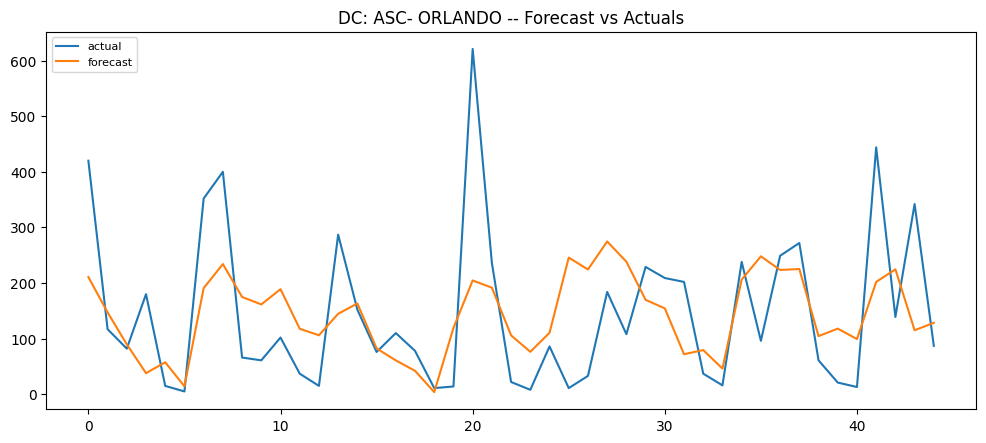

Shape of training set: (562, 50, 1)
Shape of test set: (104, 50, 1)
Epoch 1/100
18/18 - 5s - loss: 9356.6865 - val_loss: 1878.7220 - 5s/epoch - 286ms/step
Epoch 2/100
18/18 - 3s - loss: 5850.5967 - val_loss: 3269.6650 - 3s/epoch - 149ms/step
Epoch 3/100
18/18 - 3s - loss: 5127.2295 - val_loss: 2996.6045 - 3s/epoch - 151ms/step
Epoch 4/100
18/18 - 3s - loss: 5023.9458 - val_loss: 2527.6887 - 3s/epoch - 147ms/step
Epoch 5/100
18/18 - 3s - loss: 4972.7612 - val_loss: 2648.5764 - 3s/epoch - 150ms/step
Epoch 6/100
18/18 - 3s - loss: 4894.4902 - val_loss: 2451.6108 - 3s/epoch - 148ms/step
Epoch 7/100
18/18 - 3s - loss: 4838.3838 - val_loss: 2571.9888 - 3s/epoch - 149ms/step
Epoch 8/100
18/18 - 3s - loss: 4832.8823 - val_loss: 2263.8030 - 3s/epoch - 150ms/step
Epoch 9/100
18/18 - 3s - loss: 4738.4321 - val_loss: 2442.6223 - 3s/epoch - 148ms/step
Epoch 10/100
18/18 - 3s - loss: 4661.4995 - val_loss: 2273.9038 - 3s/epoch - 150ms/step
Epoch 11/100
18/18 - 3s - loss: 4637.0737 - val_loss: 2424.72

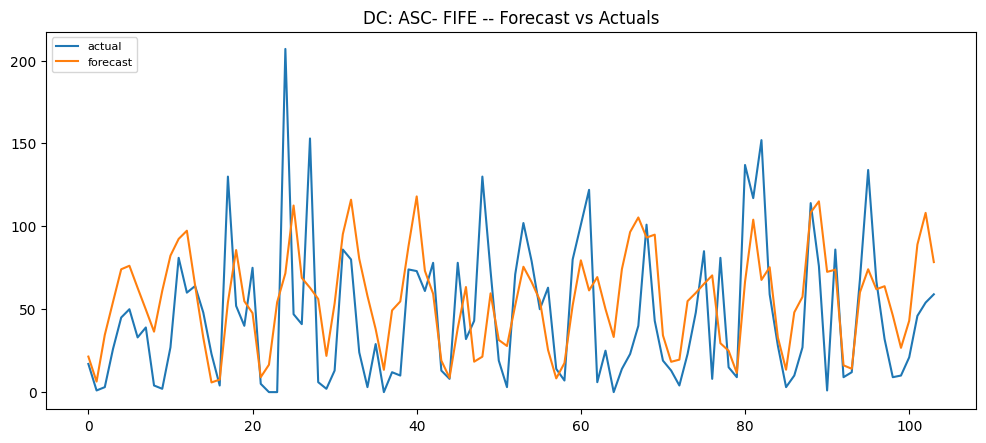

Shape of training set: (563, 50, 1)
Shape of test set: (104, 50, 1)
Epoch 1/100
18/18 - 5s - loss: 14954.3428 - val_loss: 3133.0767 - 5s/epoch - 281ms/step
Epoch 2/100
18/18 - 3s - loss: 9725.6123 - val_loss: 3364.1646 - 3s/epoch - 158ms/step
Epoch 3/100
18/18 - 3s - loss: 7782.4521 - val_loss: 4900.2920 - 3s/epoch - 155ms/step
Epoch 4/100
18/18 - 3s - loss: 7595.6626 - val_loss: 4011.3560 - 3s/epoch - 156ms/step
Epoch 5/100
18/18 - 3s - loss: 7546.0176 - val_loss: 4089.8672 - 3s/epoch - 158ms/step
Epoch 6/100
18/18 - 3s - loss: 7525.5908 - val_loss: 4184.9863 - 3s/epoch - 156ms/step
Epoch 7/100
18/18 - 3s - loss: 7503.2656 - val_loss: 3835.2998 - 3s/epoch - 156ms/step
Epoch 8/100
18/18 - 3s - loss: 7399.0205 - val_loss: 4192.4180 - 3s/epoch - 155ms/step
Epoch 9/100
18/18 - 3s - loss: 7339.2520 - val_loss: 3841.2163 - 3s/epoch - 156ms/step
Epoch 10/100
18/18 - 3s - loss: 7286.5317 - val_loss: 3729.5173 - 3s/epoch - 155ms/step
Epoch 11/100
18/18 - 3s - loss: 7205.1479 - val_loss: 3815.7

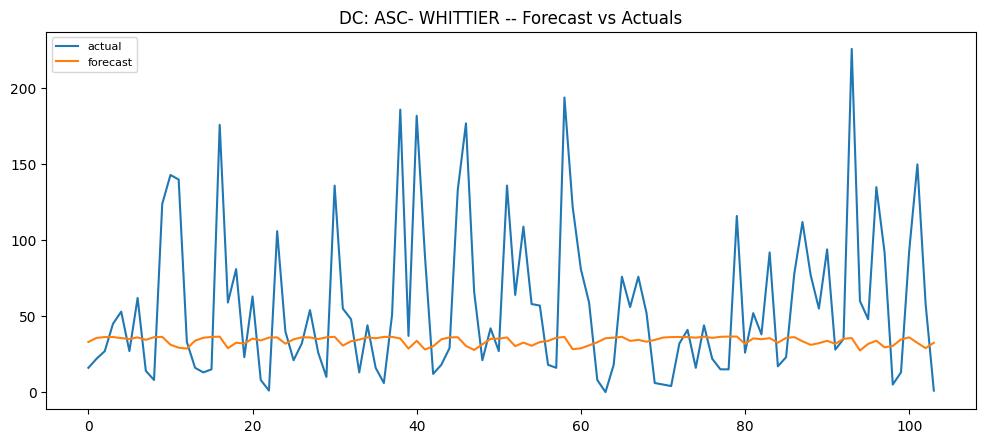

Shape of training set: (562, 50, 1)
Shape of test set: (104, 50, 1)
Epoch 1/100
18/18 - 5s - loss: 5161.1245 - val_loss: 1758.5098 - 5s/epoch - 289ms/step
Epoch 2/100
18/18 - 3s - loss: 3406.0776 - val_loss: 2220.1401 - 3s/epoch - 158ms/step
Epoch 3/100
18/18 - 3s - loss: 3242.5613 - val_loss: 1798.6315 - 3s/epoch - 157ms/step
Epoch 4/100
18/18 - 3s - loss: 3181.1660 - val_loss: 1760.4279 - 3s/epoch - 166ms/step
Epoch 5/100
18/18 - 3s - loss: 3120.1919 - val_loss: 1712.3466 - 3s/epoch - 165ms/step
Epoch 6/100
18/18 - 3s - loss: 3072.1914 - val_loss: 1751.4073 - 3s/epoch - 163ms/step
Epoch 7/100
18/18 - 3s - loss: 3011.7693 - val_loss: 1684.5333 - 3s/epoch - 166ms/step
Epoch 8/100
18/18 - 3s - loss: 2999.3269 - val_loss: 1795.4915 - 3s/epoch - 166ms/step
Epoch 9/100
18/18 - 3s - loss: 2961.0164 - val_loss: 1580.8710 - 3s/epoch - 164ms/step
Epoch 10/100
18/18 - 3s - loss: 2922.9878 - val_loss: 1906.8735 - 3s/epoch - 163ms/step
Epoch 11/100
18/18 - 3s - loss: 2906.6177 - val_loss: 1602.44

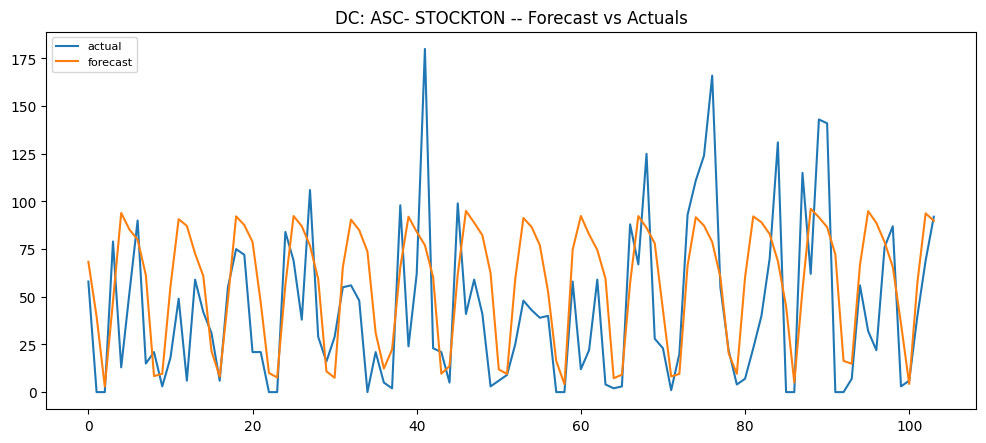

Shape of training set: (562, 50, 1)
Shape of test set: (104, 50, 1)
Epoch 1/100
18/18 - 5s - loss: 74976.5391 - val_loss: 48479.4766 - 5s/epoch - 287ms/step
Epoch 2/100
18/18 - 3s - loss: 59345.3555 - val_loss: 32989.7969 - 3s/epoch - 164ms/step
Epoch 3/100
18/18 - 3s - loss: 43133.1094 - val_loss: 24833.0312 - 3s/epoch - 168ms/step
Epoch 4/100
18/18 - 3s - loss: 37304.8555 - val_loss: 25080.9902 - 3s/epoch - 162ms/step
Epoch 5/100
18/18 - 3s - loss: 36648.6992 - val_loss: 24939.5117 - 3s/epoch - 155ms/step
Epoch 6/100
18/18 - 3s - loss: 36495.3828 - val_loss: 24575.9590 - 3s/epoch - 158ms/step
Epoch 7/100
18/18 - 3s - loss: 36420.5039 - val_loss: 24625.1543 - 3s/epoch - 157ms/step
Epoch 8/100
18/18 - 3s - loss: 36360.5234 - val_loss: 24282.5645 - 3s/epoch - 154ms/step
Epoch 9/100
18/18 - 3s - loss: 35901.3438 - val_loss: 24448.0586 - 3s/epoch - 160ms/step
Epoch 10/100
18/18 - 3s - loss: 35820.3789 - val_loss: 23998.1035 - 3s/epoch - 157ms/step
Epoch 11/100
18/18 - 3s - loss: 35563.648

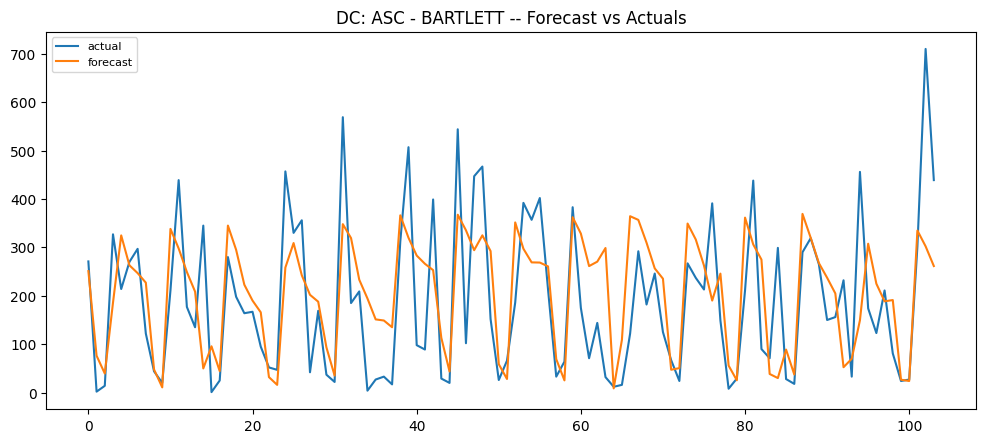

Shape of training set: (562, 50, 1)
Shape of test set: (104, 50, 1)
Epoch 1/100
18/18 - 6s - loss: 26889.3652 - val_loss: 7817.8535 - 6s/epoch - 315ms/step
Epoch 2/100
18/18 - 3s - loss: 19491.4238 - val_loss: 6711.8057 - 3s/epoch - 167ms/step
Epoch 3/100
18/18 - 3s - loss: 15698.5215 - val_loss: 8461.7275 - 3s/epoch - 176ms/step
Epoch 4/100
18/18 - 3s - loss: 15456.2148 - val_loss: 7970.3906 - 3s/epoch - 171ms/step
Epoch 5/100
18/18 - 3s - loss: 15351.0625 - val_loss: 7752.6958 - 3s/epoch - 165ms/step
Epoch 6/100
18/18 - 3s - loss: 15214.6992 - val_loss: 7380.1587 - 3s/epoch - 159ms/step
Epoch 7/100
18/18 - 3s - loss: 15021.8545 - val_loss: 7255.4341 - 3s/epoch - 172ms/step
Epoch 8/100
18/18 - 3s - loss: 14664.5986 - val_loss: 6961.8730 - 3s/epoch - 169ms/step
Epoch 9/100
18/18 - 3s - loss: 14235.0625 - val_loss: 7059.0889 - 3s/epoch - 168ms/step
Epoch 10/100
18/18 - 3s - loss: 13670.9150 - val_loss: 6936.0503 - 3s/epoch - 162ms/step
Epoch 11/100
18/18 - 3s - loss: 13066.9854 - val_lo

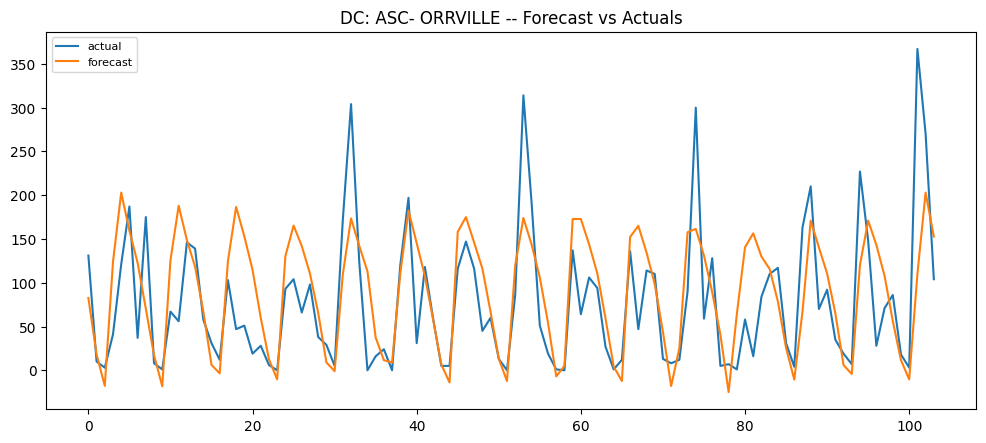

Shape of training set: (562, 50, 1)
Shape of test set: (103, 50, 1)
Epoch 1/100
18/18 - 6s - loss: 66698.9531 - val_loss: 69347.0703 - 6s/epoch - 328ms/step
Epoch 2/100
18/18 - 3s - loss: 52758.6211 - val_loss: 51486.1562 - 3s/epoch - 162ms/step
Epoch 3/100
18/18 - 3s - loss: 38870.9297 - val_loss: 38404.1367 - 3s/epoch - 168ms/step
Epoch 4/100
18/18 - 3s - loss: 34015.5078 - val_loss: 35679.2539 - 3s/epoch - 161ms/step
Epoch 5/100
18/18 - 3s - loss: 33204.9219 - val_loss: 35479.4609 - 3s/epoch - 162ms/step
Epoch 6/100
18/18 - 3s - loss: 33114.2031 - val_loss: 35254.2930 - 3s/epoch - 159ms/step
Epoch 7/100
18/18 - 3s - loss: 32956.7383 - val_loss: 35091.1641 - 3s/epoch - 164ms/step
Epoch 8/100
18/18 - 3s - loss: 32936.9102 - val_loss: 34766.0312 - 3s/epoch - 164ms/step
Epoch 9/100
18/18 - 3s - loss: 32781.3398 - val_loss: 34832.6484 - 3s/epoch - 161ms/step
Epoch 10/100
18/18 - 3s - loss: 32837.2305 - val_loss: 34654.2070 - 3s/epoch - 165ms/step
Epoch 11/100
18/18 - 3s - loss: 32576.693

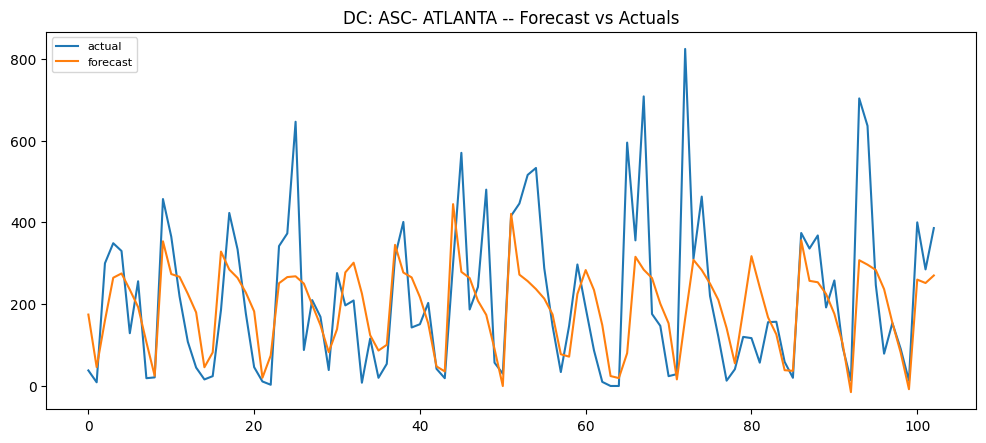

Shape of training set: (562, 50, 1)
Shape of test set: (104, 50, 1)
Epoch 1/100
18/18 - 5s - loss: 137680.8750 - val_loss: 91940.3359 - 5s/epoch - 302ms/step
Epoch 2/100
18/18 - 3s - loss: 115691.7188 - val_loss: 67193.9844 - 3s/epoch - 174ms/step
Epoch 3/100
18/18 - 3s - loss: 88844.2969 - val_loss: 48451.3086 - 3s/epoch - 164ms/step
Epoch 4/100
18/18 - 3s - loss: 73762.2734 - val_loss: 44485.5664 - 3s/epoch - 164ms/step
Epoch 5/100
18/18 - 3s - loss: 70727.8281 - val_loss: 45158.0898 - 3s/epoch - 165ms/step
Epoch 6/100
18/18 - 3s - loss: 70551.0391 - val_loss: 44961.1523 - 3s/epoch - 164ms/step
Epoch 7/100
18/18 - 3s - loss: 70522.2734 - val_loss: 44761.2695 - 3s/epoch - 164ms/step
Epoch 8/100
18/18 - 3s - loss: 70496.2031 - val_loss: 44566.6445 - 3s/epoch - 166ms/step
Epoch 9/100
18/18 - 3s - loss: 70412.2969 - val_loss: 44611.5703 - 3s/epoch - 164ms/step
Epoch 10/100
18/18 - 3s - loss: 70332.2266 - val_loss: 44915.9180 - 3s/epoch - 168ms/step
Epoch 11/100
18/18 - 3s - loss: 70603.7

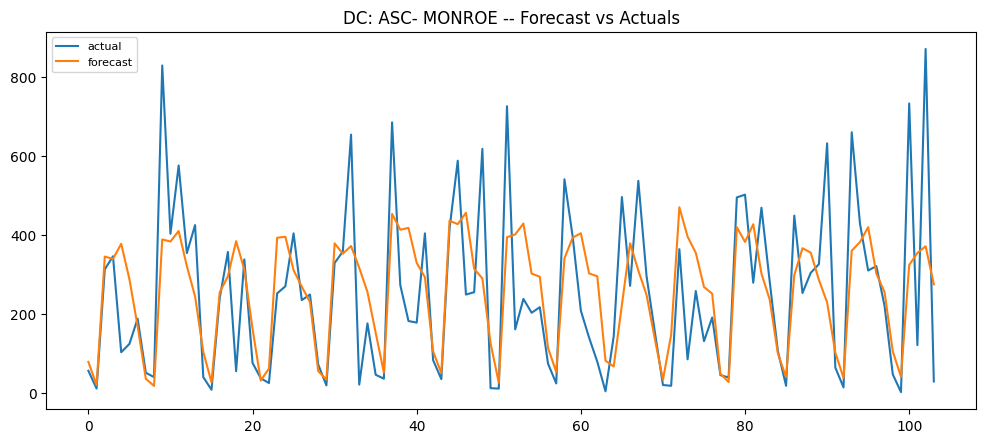

Shape of training set: (562, 50, 1)
Shape of test set: (104, 50, 1)
Epoch 1/100
18/18 - 6s - loss: 121131720.0000 - val_loss: 34588.2773 - 6s/epoch - 323ms/step
Epoch 2/100
18/18 - 3s - loss: 121113320.0000 - val_loss: 27199.0098 - 3s/epoch - 163ms/step
Epoch 3/100
18/18 - 3s - loss: 121057928.0000 - val_loss: 21031.9980 - 3s/epoch - 169ms/step
Epoch 4/100
18/18 - 3s - loss: 121000400.0000 - val_loss: 18518.1875 - 3s/epoch - 165ms/step
Epoch 5/100
18/18 - 3s - loss: 120978200.0000 - val_loss: 19194.6426 - 3s/epoch - 171ms/step
Epoch 6/100
18/18 - 3s - loss: 120929056.0000 - val_loss: 21062.4805 - 3s/epoch - 164ms/step
Epoch 7/100
18/18 - 3s - loss: 120910176.0000 - val_loss: 25018.9473 - 3s/epoch - 168ms/step
Epoch 8/100
18/18 - 3s - loss: 120878504.0000 - val_loss: 28389.9668 - 3s/epoch - 165ms/step
Epoch 9/100
18/18 - 3s - loss: 120858176.0000 - val_loss: 33768.2109 - 3s/epoch - 164ms/step
Epoch 10/100
18/18 - 3s - loss: 120842632.0000 - val_loss: 41447.4531 - 3s/epoch - 165ms/step
E

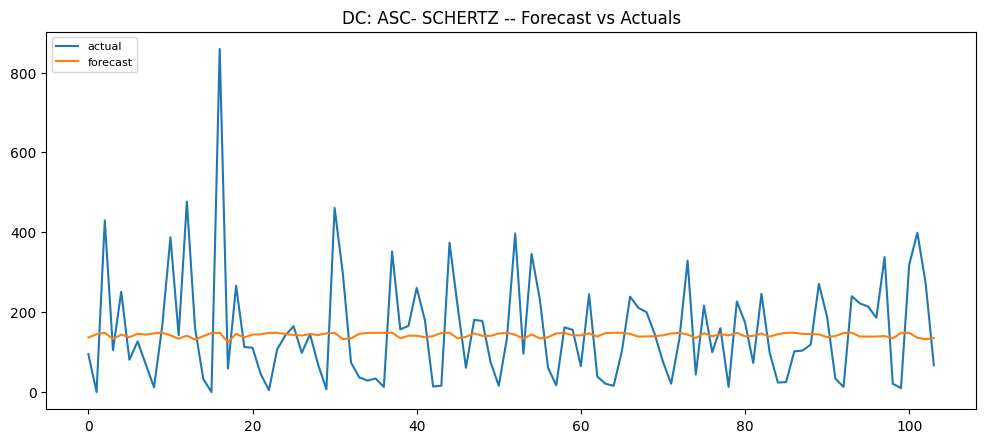

Shape of training set: (562, 50, 1)
Shape of test set: (103, 50, 1)
Epoch 1/100
18/18 - 6s - loss: 11815.4434 - val_loss: 1070.8923 - 6s/epoch - 336ms/step
Epoch 2/100
18/18 - 3s - loss: 7440.7026 - val_loss: 4428.4185 - 3s/epoch - 166ms/step
Epoch 3/100
18/18 - 3s - loss: 6498.4043 - val_loss: 4300.6279 - 3s/epoch - 162ms/step
Epoch 4/100
18/18 - 3s - loss: 6402.5801 - val_loss: 3675.0833 - 3s/epoch - 161ms/step
Epoch 5/100
18/18 - 3s - loss: 6360.6582 - val_loss: 3825.8589 - 3s/epoch - 164ms/step
Epoch 6/100
18/18 - 3s - loss: 6308.8247 - val_loss: 3391.3616 - 3s/epoch - 166ms/step
Epoch 7/100
18/18 - 3s - loss: 6263.2583 - val_loss: 3203.7810 - 3s/epoch - 166ms/step
Epoch 8/100
18/18 - 3s - loss: 6223.6250 - val_loss: 3162.6147 - 3s/epoch - 160ms/step
Epoch 9/100
18/18 - 3s - loss: 6146.5610 - val_loss: 2954.9512 - 3s/epoch - 163ms/step
Epoch 10/100
18/18 - 3s - loss: 6068.5645 - val_loss: 2961.1738 - 3s/epoch - 155ms/step
Epoch 11/100
18/18 - 3s - loss: 6018.5688 - val_loss: 2523.0

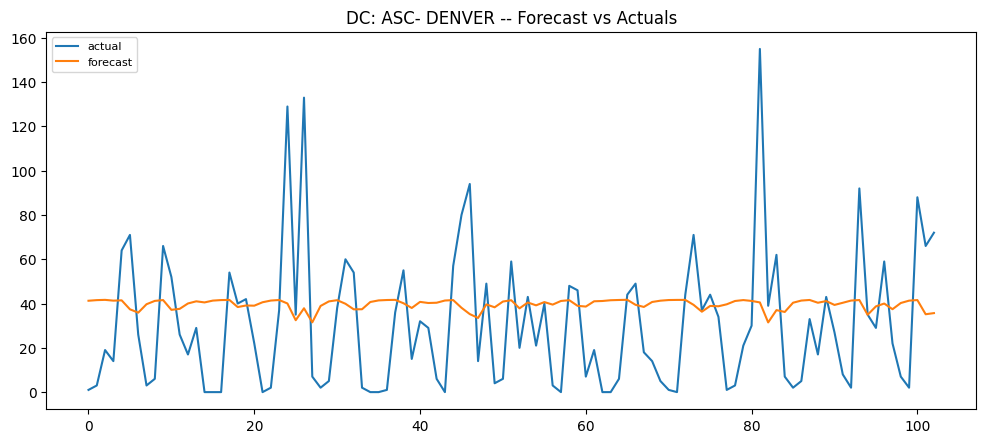

In [ ]:
def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-SEQUENCE_SIZE):
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

SEQUENCE_SIZE = 50
result_printout = []
for i in range(len(DC)):
  dtst = data[data["Primary Warehouse"] == DC[i]]
  # daily
  dtst = dtst.groupby(["Order Date"])["Order Quantity"].agg("sum")
  dtst = dtst.reset_index()
  dtst.set_index("Order Date", inplace=True)
  dtst = dtst.asfreq(freq='d',fill_value=0)
  
  TRAIN = int(len(dtst)*0.80)
  trainset = dtst.iloc[:TRAIN, :]
  testset = dtst.iloc[TRAIN:, :]

  order_train = trainset['Order Quantity'].tolist()
  order_test = testset['Order Quantity'].tolist()

  x_train,y_train = to_sequences(SEQUENCE_SIZE,order_train)
  x_test,y_test = to_sequences(SEQUENCE_SIZE,order_test)

  print("Shape of training set: {}".format(x_train.shape))
  print("Shape of test set: {}".format(x_test.shape))

  model = build_model()
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
                        verbose=1, mode='auto', restore_best_weights=True)
  model.fit(x_train,y_train,validation_data=(x_test,y_test),
            callbacks=[monitor],verbose=2,epochs=100)
  
  pred = model.predict(x_test)

  #++++++++++ PLOT WILL BE SEALED++++++++++++++++++++++++++
  plt.figure(figsize=(12,5), dpi=100)
  plt.plot(y_test, label='actual')
  plt.plot(pred, label='forecast')

  plt.title('DC: %s -- Forecast vs Actuals' %DC[i])
  plt.legend(loc='upper left', fontsize=8)
  plt.show()
  #++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
for i in result_printout:
  print(i)

{'mape': 1.1537561328964983, 'me': -8.401006062825521, 'mae': 80.94263441297743, 'mpe': 0.8486927879813346, 'rmse': 107.36811343415347, 'acf1': -0.07763542308536599, 'corr': 0.6533589244683261, 'minmax': 0.4455951274208505}
{'mape': inf, 'me': -2.3387619898869443, 'mae': 34.50718314831074, 'mpe': inf, 'rmse': 42.86287017578086, 'acf1': 0.23242818109221683, 'corr': -0.10248734351158695, 'minmax': 0.5472616281785164}
{'mape': inf, 'me': -17.850044910724346, 'mae': 39.01559572953444, 'mpe': inf, 'rmse': 54.03924499167244, 'acf1': 0.21457786190272832, 'corr': -0.0847040800393855, 'minmax': 0.5149979782749114}
{'mape': inf, 'me': 3.571478731930256, 'mae': 27.507520388525265, 'mpe': nan, 'rmse': 36.30965113144353, 'acf1': 0.0746611094728302, 'corr': 0.5096509636600242, 'minmax': inf}
{'mape': 2.4918635569204364, 'me': 6.287630695563096, 'mae': 97.11809577391698, 'mpe': 2.195676843497864, 'rmse': 131.73430096749829, 'acf1': -0.01815732441693475, 'corr': 0.5676055759313878, 'minmax': 0.4046256

In [ ]:
# order_train = trainset['Order Quantity'].tolist()
# order_test = testset['Order Quantity'].tolist()

# print("Training set has {} observations.".format(len(order_train )))
# print("Test set has {} observations.".format(len(order_test)))

Training set has 4717 observations.
Test set has 525 observations.


In [ ]:
# def to_sequences(seq_size, obs):
#     x = []
#     y = []

#     for i in range(len(obs)-SEQUENCE_SIZE):
#         window = obs[i:(i+SEQUENCE_SIZE)]
#         after_window = obs[i+SEQUENCE_SIZE]
#         window = [[x] for x in window]
#         x.append(window)
#         y.append(after_window)
        
#     return np.array(x),np.array(y)
    
# SEQUENCE_SIZE = 100
# x_train,y_train = to_sequences(SEQUENCE_SIZE,order_train)
# x_test,y_test = to_sequences(SEQUENCE_SIZE,order_test)

# print("Shape of training set: {}".format(x_train.shape))
# print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (4617, 100, 1)
Shape of test set: (425, 100, 1)


In [ ]:
# from tensorflow.keras.preprocessing import sequence
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Embedding
# from tensorflow.keras.layers import LSTM
# from tensorflow.keras.callbacks import EarlyStopping

# print('Build model...')
# model = Sequential()
# model.add(LSTM(256, dropout=0.0, recurrent_dropout=0.0,input_shape=(None, 1)))
# model.add(Dense(64))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
#                         verbose=1, mode='auto', restore_best_weights=True)
# print('Train...')

# model.fit(x_train,y_train,validation_data=(x_test,y_test),
#           callbacks=[monitor],verbose=2,epochs=1000)

Build model...
Train...
Epoch 1/1000
145/145 - 56s - loss: 344.6099 - val_loss: 91.9184 - 56s/epoch - 383ms/step
Epoch 2/1000
145/145 - 59s - loss: 342.5308 - val_loss: 111.5570 - 59s/epoch - 406ms/step
Epoch 3/1000
145/145 - 45s - loss: 343.4562 - val_loss: 104.8386 - 45s/epoch - 310ms/step
Epoch 4/1000
145/145 - 48s - loss: 343.4917 - val_loss: 94.7436 - 48s/epoch - 333ms/step
Epoch 5/1000
145/145 - 43s - loss: 342.9131 - val_loss: 95.8551 - 43s/epoch - 298ms/step
Epoch 6/1000
145/145 - 43s - loss: 341.9297 - val_loss: 109.7919 - 43s/epoch - 296ms/step
Epoch 7/1000
145/145 - 44s - loss: 342.4504 - val_loss: 96.6450 - 44s/epoch - 307ms/step
Epoch 8/1000
145/145 - 46s - loss: 341.4663 - val_loss: 98.8740 - 46s/epoch - 319ms/step
Epoch 9/1000
145/145 - 43s - loss: 342.0625 - val_loss: 98.6677 - 43s/epoch - 300ms/step
Epoch 10/1000
145/145 - 44s - loss: 342.2711 - val_loss: 91.6497 - 44s/epoch - 300ms/step
Epoch 11/1000
145/145 - 44s - loss: 342.2543 - val_loss: 101.0905 - 44s/epoch - 30

In [ ]:
# from sklearn import metrics

# pred = model.predict(x_test)
# score = np.sqrt(metrics.mean_squared_error(pred,y_test))
# print("Score (RMSE): {}".format(score)) # more small rmse

Score (RMSE): 9.381037748306031


In [ ]:
resp_pred = pred.reshape(-1,)

In [ ]:
forecast_accuracy(resp_pred,y_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


{'acf1': 0.03455843494730378,
 'corr': -0.0002650393689014773,
 'mae': 5.861908889097326,
 'mape': 1.8100920548181072,
 'me': -0.5300310303183163,
 'minmax': 0.5354223906841631,
 'mpe': 1.5039444315751562,
 'rmse': 9.256598410690389}

#### CNN Model

In [ ]:
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout, MaxPooling1D, Flatten

print('Build model...')
model = Sequential()
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', 
                 input_shape=(SEQUENCE_SIZE,1)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
                        verbose=1, mode='auto', restore_best_weights=True)
print('Train...')

model.fit(x_train,y_train,validation_data=(x_test,y_test),
          callbacks=[monitor],verbose=2,epochs=1000)

Build model...
Train...
Epoch 1/1000
145/145 - 3s - loss: 360.4142 - val_loss: 86.7254 - 3s/epoch - 18ms/step
Epoch 2/1000
145/145 - 2s - loss: 347.3943 - val_loss: 85.7099 - 2s/epoch - 12ms/step
Epoch 3/1000
145/145 - 2s - loss: 344.2951 - val_loss: 85.6846 - 2s/epoch - 16ms/step
Epoch 4/1000
145/145 - 2s - loss: 338.9895 - val_loss: 86.4484 - 2s/epoch - 15ms/step
Epoch 5/1000
145/145 - 2s - loss: 335.8095 - val_loss: 89.1106 - 2s/epoch - 16ms/step
Epoch 6/1000
145/145 - 2s - loss: 333.9718 - val_loss: 87.5396 - 2s/epoch - 14ms/step
Epoch 7/1000
145/145 - 2s - loss: 326.8157 - val_loss: 87.0906 - 2s/epoch - 12ms/step
Epoch 8/1000
145/145 - 2s - loss: 321.9860 - val_loss: 87.5213 - 2s/epoch - 12ms/step
Epoch 9/1000
145/145 - 2s - loss: 305.1750 - val_loss: 91.3556 - 2s/epoch - 12ms/step
Epoch 10/1000
145/145 - 2s - loss: 291.3905 - val_loss: 88.3380 - 2s/epoch - 12ms/step
Epoch 11/1000
145/145 - 2s - loss: 275.2677 - val_loss: 92.2180 - 2s/epoch - 12ms/step
Epoch 12/1000
145/145 - 2s -

In [ ]:
# from sklearn import metrics
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred.flatten(),y_test))
print("Score (RMSE): {}".format(score))

Score (RMSE): 9.256598410690389


In [ ]:
resp_pred = pred.reshape(-1,)
forecast_accuracy(resp_pred,y_test)

In [ ]:
x_test.reshape(425,-1).shape

(425, 100)

In [ ]:
y_train.shape

(4617,)

## DATA-2
- Info Extraction

In [ ]:
import pandas as pd
sheet3 = pd.read_excel(file_path,sheet_name="Safety Stock")

In [ ]:
sheet3.iloc[100:110,:]

,Helper,DC,Item,Description,Safety Stock (EA)
100,900583566,900,583566,Renal Support-A Dry 6.6#-Cat,12
101,900583603,900,583603,MULTI Urnry + Satiety 6.6#-Cat,4
102,900583703,900,583703,MULTI Renal + HP 6.6#-Cat,20
103,900583803,900,583803,MULTI Urinary + HP 6.6#-Cat,16
104,900583808,900,583808,MULTI Urinary +HP 17.6#-Cat,4
105,900584003,900,584003,MULTI Urinary + Calm 6.6#-Cat,16
106,900584008,900,584008,MULTI Urinary + Calm 17.6#-Cat,16
107,900584425,900,584425,Ultamino Dry 5.5#-Cat,4
108,90060401,900,60401,Urinary SO Can 13.5 oz / 385 g,1620
109,90060434,900,60434,Urinary SO MIG Can 24/3oz-Cat,2856


In [ ]:
sheet3.head()

,Helper,DC,Item,Description,Safety Stock (EA),weights
0,900260205,900,260205,Recovery Can 24/5.8oz,508,"[24, 5.8, oz]"
1,900302110,900,302110,Sel Pro PV Can 24/13.5 oz-Dog,804,"[24, 13.5, oz, g]"
2,900302210,900,302210,Sel Pro PR Can 24/13.5 oz-Dog,628,"[24, 13.5, oz, g]"
3,900302310,900,302310,Sel Pro PW Can 24/13.5 oz-Dog,292,"[24, 13.5, oz, g]"
4,900302710,900,302710,Skin Support Dry 6#-Dog,4,"[6, #, g]"


**I want to extract the weights for each item**

In [ ]:
sample = 'Skin Support Dry 6#-Dog	'
pattern = r"(\d+\.?\d*.?oz)|(\d+\.?\d*.?#)|(\d+\.?\d*.?g)|(\d+\.?\d*)"

In [ ]:
import re
compStr = re.compile(pattern)
compStr.findall(sample)

[('', '6#', '', '')]

In [ ]:
sheet3['weights'] = sheet3['Description'].apply(lambda desc: compStr.findall(desc))

1 oz = 28.350 g

In [ ]:
oz = 28.350

In [ ]:
sheet3

,Helper,DC,Item,Description,Safety Stock (EA),weights
0,900260205,900,260205,Recovery Can 24/5.8oz,508,"[(, , , 24), (5.8oz, , , )]"
1,900302110,900,302110,Sel Pro PV Can 24/13.5 oz-Dog,804,"[(, , , 24), (13.5 oz, , , )]"
2,900302210,900,302210,Sel Pro PR Can 24/13.5 oz-Dog,628,"[(, , , 24), (13.5 oz, , , )]"
3,900302310,900,302310,Sel Pro PW Can 24/13.5 oz-Dog,292,"[(, , , 24), (13.5 oz, , , )]"
4,900302710,900,302710,Skin Support Dry 6#-Dog,4,"[(, 6#, , )]"
...,...,...,...,...,...,...
2973,912771513,912,771513,HYDRO PROT CAN 24/13.7 oz-Dog,10453,"[(, , , 24), (13.7 oz, , , )]"
2974,912800010,912,800010,Pill Assist Feline 1.6 oz,1061,"[(1.6 oz, , , )]"
2975,912800031,912,800031,Pill Assist Sm Dog 3.2 oz,176,"[(3.2 oz, , , )]"
2976,912800075,912,800075,Pill Assist LG Dog 7.9 oz,485,"[(7.9 oz, , , )]"


In [ ]:
for i in sheet3.weights:
  print(i)

[('', '', '', '24'), ('5.8oz', '', '', '')]
[('', '', '', '24'), ('13.5 oz', '', '', '')]
[('', '', '', '24'), ('13.5 oz', '', '', '')]
[('', '', '', '24'), ('13.5 oz', '', '', '')]
[('', '6#', '', '')]
[('', '16.5#', '', '')]
[('12.5oz', '', '', ''), ('', '', '355g', '')]
[('', '', '', '24'), ('3oz', '', '', '')]
[('', '', '', '24'), ('', '', '', '85')]
[('', '', '', '12'), ('13.5oz', '', '', '')]
[('', '17.6#', '', '')]
[('', '', '', '12'), ('13.5oz', '', '', '')]
[('', '', '385g', '')]
[('', '25.3#', '', '')]
[('', '6.6#', '', '')]
[('', '', '', '24'), ('', '', '', '13.4')]
[('', '17.6#', '', '')]
[('', '25.3#', '', '')]
[('', '7.7#', '', '')]
[('', '17.6#', '', '')]
[('', '7.7#', '', '')]
[('', '7.7#', '', '')]
[('', '', '', '24'), ('14.5oz', '', '', '')]
[('', '', '', '24'), ('3oz', '', '', '')]
[('13.5oz', '', '', ''), ('', '', '385g', '')]
[('', '', '', '24'), ('5.1oz', '', '', '')]
[('', '', '', '5.1'), ('', '', '', '145')]
[('5.1oz', '', '', ''), ('', '', '', '145')]
[('', '',

In [ ]:
# sheet3['weights'].apply(lambda x: ele. for tup in x for ele in tup if ele.find('oz') != -1)

In [ ]:
'13.5oz'.find('oz')

4

**Sheet 1: Forecast**

In [ ]:
sheet1 = pd.read_excel(file_path,sheet_name="Forecast")

In [ ]:
sheet1.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,P2 2022,P2 2022.1,P2 2022.2,P2 2022.3,P3 2022,P3 2022.1,P3 2022.2,P3 2022.3,P4 2022,P4 2022.1,P4 2022.2,P4 2022.3,P5 2022,P5 2022.1,P5 2022.2,P5 2022.3,P6 2022,P6 2022.1,P6 2022.2,P6 2022.3,P7 2022,P7 2022.1,P7 2022.2,P7 2022.3,P8 2022,P8 2022.1,P8 2022.2,P8 2022.3,P9 2022,P9 2022.1,P9 2022.2,P9 2022.3,P10 2022,P10 2022.1,P10 2022.2,P10 2022.3,P11 2022,P11 2022.1,P11 2022.2,P11 2022.3,P12 2022,P12 2022.1,P12 2022.2,P12 2022.3,P13 2022,P13 2022.1,P13 2022.2,P13 2022.3
0,Helper,DC Code,Item,DC Name,Time series,W01/P02(W05) 2022,W02/P02(W06) 2022,W03/P02(W07) 2022,W04/P02(W08) 2022,W01/P03(W09) 2022,W02/P03(W10) 2022,W03/P03(W11) 2022,W04/P03(W12) 2022,W01/P04(W13) 2022,W02/P04(W14) 2022,W03/P04(W15) 2022,W04/P04(W16) 2022,W01/P05(W17) 2022,W02/P05(W18) 2022,W03/P05(W19) 2022,W04/P05(W20) 2022,W01/P06(W21) 2022,W02/P06(W22) 2022,W03/P06(W23) 2022,W04/P06(W24) 2022,W01/P07(W25) 2022,W02/P07(W26) 2022,W03/P07(W27) 2022,W04/P07(W28) 2022,W01/P08(W29) 2022,W02/P08(W30) 2022,W03/P08(W31) 2022,W04/P08(W32) 2022,W01/P09(W33) 2022,W02/P09(W34) 2022,W03/P09(W35) 2022,W04/P09(W36) 2022,W01/P10(W37) 2022,W02/P10(W38) 2022,W03/P10(W39) 2022,W04/P10(W40) 2022,W01/P11(W41) 2022,W02/P11(W42) 2022,W03/P11(W43) 2022,W04/P11(W44) 2022,W01/P12(W45) 2022,W02/P12(W46) 2022,W03/P12(W47) 2022,W04/P12(W48) 2022,W01/P13(W49) 2022,W02/P13(W50) 2022,W03/P13(W51) 2022,W04/P13(W52) 2022
1,90410674000,904,10674000,ABAR,Initial Forecast (EA),3,4,3,3,3,4,3,3,3,4,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,902111103,902,111103,AATL,Initial Forecast (EA),10,12,10,11,10,12,10,11,10,12,10,11,10,12,10,11,10,12,10,11,10,12,10,11,10,12,10,11,10,12,10,11,10,12,10,11,10,12,10,11,11,13,10,11,11,13,10,11
3,904111103,904,111103,ABAR,Initial Forecast (EA),21,27,23,23,22,27,23,23,22,27,23,23,14,16,13,13,14,16,13,13,14,16,13,14,14,16,13,14,14,16,14,14,14,16,14,14,14,16,14,14,14,16,14,14,14,17,14,14
4,906111103,906,111103,ADEN,Initial Forecast (EA),6,10,7,8,6,9,7,8,6,9,7,8,3,4,3,3,3,3,3,3,3,4,3,3,3,4,3,3,3,4,3,3,3,4,3,3,3,4,4,4,3,4,4,4,3,4,3,3


In [ ]:
sheet1.drop(['Unnamed: 0','Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1, inplace=True)
sheet1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054 entries, 0 to 3053
Data columns (total 49 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 1  3054 non-null   object
 1   P2 2022     2829 non-null   object
 2   P2 2022.1   2829 non-null   object
 3   P2 2022.2   2829 non-null   object
 4   P2 2022.3   2829 non-null   object
 5   P3 2022     2829 non-null   object
 6   P3 2022.1   2829 non-null   object
 7   P3 2022.2   2829 non-null   object
 8   P3 2022.3   2829 non-null   object
 9   P4 2022     2842 non-null   object
 10  P4 2022.1   2843 non-null   object
 11  P4 2022.2   2843 non-null   object
 12  P4 2022.3   2843 non-null   object
 13  P5 2022     2793 non-null   object
 14  P5 2022.1   2794 non-null   object
 15  P5 2022.2   2793 non-null   object
 16  P5 2022.3   2794 non-null   object
 17  P6 2022     2781 non-null   object
 18  P6 2022.1   2781 non-null   object
 19  P6 2022.2   2781 non-null   object
 20  P6 2022.

## ARIMA - Weekly order quantity

**1. Load the data**

**2. Preprocessing**

**3. Make series stationary**

**4. Determine d value**

**5. Create ACF and PACF plots**

- 0: (1, 1)
- 1: ().....

**6. Determine the p and q values**

In [ ]:
from statsmodels.tsa.stattools import acf
"""
Mean Absolute Percentage Error (MAPE)
Around 2.2% MAPE implies the model is about 97.8% accurate in predicting the next 15 observations.
Mean Error (ME)
Mean Absolute Error (MAE)
Mean Percentage Error (MPE)
Root Mean Squared Error (RMSE)
Lag 1 Autocorrelation of Error (ACF1)
Correlation between the Actual and the Forecast (corr)
Min-Max Error (minmax)
"""
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

**7. Fit ARIMA model**

**8. Predict values on validation set**

**9. Calculate RMSE**

The accuracy is not good?
- use one year weekly data to predict one forward week result
- continue to slice one year data [2019-12-wk1, ...., 2020-12-wk1] --> [2021-wk1]
- result: [2021-wk1, 2021-wk2, ......]
- actual: [2021-wk1, .....]
- rmse?

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [ ]:
import pandas as pd
import numpy as np
from dateutil.parser import parse
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

file='/content/drive/My Drive/projects/royalcanin.xlsx' 
data=pd.read_excel(file, parse_dates=["Order Date"])
data.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,Order Date,Order Quantity,Stock Unit of Measure,Product SKU,Primary Warehouse,Primary Warehouse Zip Postal Code
0,2019-12-30,3.0,EA,563305,ASC- ORLANDO,32809.0
1,2019-12-30,2.0,EA,760217,ASC- FIFE,98424.0
2,2019-12-30,1.0,EA,664003,ASC- ORLANDO,32809.0
3,2019-12-30,2.0,EA,771513,ASC- ORLANDO,32809.0
4,2019-12-30,2.0,EA,472177,ASC- ORLANDO,32809.0


ROYAL CANIN ARIMA FORECASTING API:
- INPUT:
  - time series data ["order quantity"] (required to be preprocessed as a proper data series)
  - history period: how many periods considered as history data for ARIMA model
  - forecast period: how many periods the forecasting model output
  - gridSearch: it controls for hyperparameters tuning
- OUTPUT:
  - forecasting results stored in a series

In [ ]:
%run '/content/drive/My Drive/projects/ARIMAforecasting.py'

In [ ]:
if __name__ == "__main__":
  DC = ['ASC- ORLANDO', 'ASC- FIFE', 'ASC- WHITTIER', 'ASC- STOCKTON',
      'ASC - BARTLETT', 'ASC- ORRVILLE', 'ASC- ATLANTA', 'ASC- MONROE',
       'ASC- SCHERTZ', 'ASC- DENVER']
  
  metrics_result = dict()
  # for each warehouse, first slice the sku with the largest demand and observation number (try top 10)
  for dc in DC:
    # Indicating it is training for dc
    print("===========Training Start: DC %s=================" %(dc))
    # each warehouse
    dt = data[data["Primary Warehouse"]==dc]
    # which are the fast moving SKUs
    grp_dt = dt.groupby(["Product SKU","Order Date"]).agg({"Order Quantity":"sum"}).reset_index()
    # sorted by sku quantity in descending order (filter out the order date less than 30)
    fastMv = grp_dt.groupby(["Product SKU"]).agg({"Order Quantity": "sum", "Order Date":"count"}).sort_values(by='Order Quantity', ascending=False)
    fastMv = fastMv[fastMv["Order Date"] > 30]

    # fast moving sku: 
    SKUs = fastMv.index
    
    metrics_sku = dict()
    # each fast moving sku data
    for idx in SKUs:
      print("==========There are %d fast moving SKUs in DC %s==========" %(len(SKUs),dc))
      skuDT = dt[dt["Product SKU"] == idx]
      grp_skuDT = skuDT.groupby(["Order Date"])["Order Quantity"].agg("sum")
      grp_skuDT = grp_skuDT.reset_index()
      grp_skuDT.set_index("Order Date", inplace=True)
      # daily order quantity for each sku in each DC
      grp_skuDT = grp_skuDT.asfreq(freq='d',fill_value=0)

      # weekly order quantity for each DC
      grp_skuDT = grp_skuDT.reset_index()
      wk_skuDT = grp_skuDT.resample('W-Mon',label='right',closed='right',on='Order Date')\
      .sum().reset_index().sort_values(by='Order Date')
      wk_skuDT.set_index("Order Date", inplace=True)

      rcf = RCforecast(data=wk_skuDT, window=20)
      rcf_result = rcf.main()

      #++++++++++ PLOT WILL BE SEALED++++++++++++++++++++++++++
      plt.figure(figsize=(12,5), dpi=100)
      plt.plot(wk_skuDT["Order Quantity"], label='training')
      plt.plot(wk_skuDT.iloc[20:,0], label='actual')
      predict_orders = pd.Series(rcf_result, index=wk_skuDT.iloc[20:,:].index)
      plt.plot(predict_orders, label='forecast')

      plt.title('DC: %s SKU: %s -- Forecast vs Actuals' %(dc,idx))
      plt.legend(loc='upper left', fontsize=8)
      plt.show()
      #++++++++++++++++++++++++++++++++++++++++++++++++++++++++

===========Training Start: DC ASC- ORLANDO=================
==========There are 6 fast moving SKUs in DC ASC- ORLANDO==========
There are 68 total periods
It will run 48 loops
ARIMA(1, 0, 2) RMSE=28.780
ARIMA(2, 0, 1) RMSE=31.941
ARIMA(3, 0, 1) RMSE=28.528
ARIMA(4, 0, 1) RMSE=55.529
ARIMA(4, 0, 2) RMSE=32.240
ARIMA(5, 0, 1) RMSE=55.795
ARIMA(5, 0, 2) RMSE=30.114
ARIMA(6, 0, 1) RMSE=50.708
ARIMA(6, 0, 3) RMSE=81.243
ARIMA(7, 0, 1) RMSE=21.564
ARIMA(7, 0, 2) RMSE=3.962
ARIMA(8, 0, 1) RMSE=95.831
ARIMA(8, 0, 2) RMSE=7.741
ARIMA(8, 0, 3) RMSE=20.673
Best ARIMA(7, 0, 2) RMSE=3.962
Processing time: 62
ARIMA(1, 0, 2) RMSE=53.013
ARIMA(2, 0, 1) RMSE=51.374
ARIMA(3, 0, 1) RMSE=49.135
ARIMA(4, 0, 1) RMSE=102.811
ARIMA(5, 0, 1) RMSE=112.612
ARIMA(5, 0, 2) RMSE=129.193
ARIMA(5, 0, 5) RMSE=145.987
ARIMA(6, 0, 1) RMSE=120.131
ARIMA(6, 0, 4) RMSE=123.891
ARIMA(7, 0, 1) RMSE=123.555
ARIMA(7, 0, 2) RMSE=144.106
ARIMA(8, 0, 1) RMSE=183.242
ARIMA(8, 0, 2) RMSE=138.074
ARIMA(8, 0, 3) RMSE=155.581
ARIMA(8,

===========Training Start: DC ASC- ORLANDO=================
==========There are 6 fast moving SKUs in DC ASC- ORLANDO==========
There are 68 total periods
It will run 48 loops
ARIMA(1, 0, 2) RMSE=28.780
ARIMA(2, 0, 1) RMSE=31.941
ARIMA(3, 0, 1) RMSE=28.528
ARIMA(4, 0, 1) RMSE=55.529
ARIMA(4, 0, 2) RMSE=32.240
ARIMA(5, 0, 1) RMSE=55.795
ARIMA(5, 0, 2) RMSE=30.114
ARIMA(6, 0, 1) RMSE=50.708
ARIMA(6, 0, 3) RMSE=81.243
ARIMA(7, 0, 1) RMSE=21.564
ARIMA(7, 0, 2) RMSE=3.962
ARIMA(8, 0, 1) RMSE=95.831
ARIMA(8, 0, 2) RMSE=7.741
ARIMA(8, 0, 3) RMSE=20.673
Best ARIMA(7, 0, 2) RMSE=3.962
Processing time: 55
ARIMA(1, 0, 2) RMSE=53.013
ARIMA(2, 0, 1) RMSE=51.374
ARIMA(3, 0, 1) RMSE=49.135
ARIMA(4, 0, 1) RMSE=102.811
ARIMA(5, 0, 1) RMSE=112.612
ARIMA(5, 0, 2) RMSE=129.193
ARIMA(5, 0, 5) RMSE=145.987
ARIMA(6, 0, 1) RMSE=120.131
ARIMA(6, 0, 4) RMSE=123.891
ARIMA(7, 0, 1) RMSE=123.555
ARIMA(7, 0, 2) RMSE=144.106
ARIMA(8, 0, 1) RMSE=183.242
ARIMA(8, 0, 2) RMSE=138.074
ARIMA(8, 0, 3) RMSE=155.581
ARIMA(8,

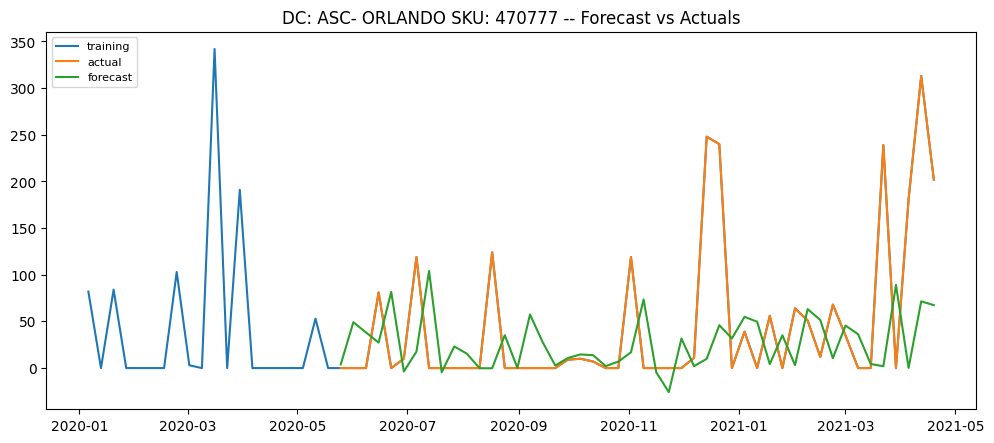

==========There are 6 fast moving SKUs in DC ASC- ORLANDO==========
There are 65 total periods
It will run 45 loops
ARIMA(1, 1, 2) RMSE=27.321
ARIMA(2, 1, 1) RMSE=24.813
ARIMA(2, 1, 2) RMSE=33.919
ARIMA(3, 1, 1) RMSE=16.995
ARIMA(3, 1, 2) RMSE=31.077
ARIMA(3, 1, 9) RMSE=73.118
ARIMA(4, 1, 1) RMSE=14.971
ARIMA(4, 1, 2) RMSE=34.856
ARIMA(4, 1, 3) RMSE=41.028
ARIMA(4, 1, 4) RMSE=25.779
ARIMA(5, 1, 1) RMSE=20.292
ARIMA(5, 1, 2) RMSE=13.773
ARIMA(5, 1, 3) RMSE=24.235
ARIMA(5, 1, 4) RMSE=40.691
ARIMA(5, 1, 5) RMSE=0.217
ARIMA(6, 1, 1) RMSE=21.307
ARIMA(6, 1, 2) RMSE=31.029
ARIMA(6, 1, 4) RMSE=30.443
ARIMA(6, 1, 5) RMSE=41.291
ARIMA(6, 1, 6) RMSE=38.563
ARIMA(6, 1, 7) RMSE=45.947
ARIMA(6, 1, 9) RMSE=41.058
ARIMA(7, 1, 1) RMSE=23.274
ARIMA(7, 1, 6) RMSE=35.998
ARIMA(8, 1, 1) RMSE=22.940
ARIMA(8, 1, 3) RMSE=33.390
ARIMA(8, 1, 4) RMSE=41.381
ARIMA(8, 1, 7) RMSE=37.479
ARIMA(9, 1, 6) RMSE=51.610
ARIMA(9, 1, 7) RMSE=54.538
Best ARIMA(5, 1, 5) RMSE=0.217
Processing time: 209
ARIMA(1, 2, 1) RMSE=7.0

In [ ]:
if __name__ == "__main__":
  DC = ['ASC- ORLANDO', 'ASC- FIFE', 'ASC- WHITTIER', 'ASC- STOCKTON',
      'ASC - BARTLETT', 'ASC- ORRVILLE', 'ASC- ATLANTA', 'ASC- MONROE',
       'ASC- SCHERTZ', 'ASC- DENVER']
  
  metrics_result = dict()
  # for each warehouse, first slice the sku with the largest demand and observation number (try top 10)
  for dc in DC:
    # Indicating it is training for dc
    print("===========Training Start: DC %s=================" %(dc))
    # each warehouse
    dt = data[data["Primary Warehouse"]==dc]
    # which are the fast moving SKUs
    grp_dt = dt.groupby(["Product SKU","Order Date"]).agg({"Order Quantity":"sum"}).reset_index()
    # sorted by sku quantity in descending order (filter out the order date less than 30)
    fastMv = grp_dt.groupby(["Product SKU"]).agg({"Order Quantity": "sum", "Order Date":"count"}).sort_values(by='Order Quantity', ascending=False)
    fastMv = fastMv[fastMv["Order Date"] > 30]

    # fast moving sku: 
    SKUs = fastMv.index
    
    metrics_sku = dict()
    # each fast moving sku data
    for idx in SKUs:
      print("==========There are %d fast moving SKUs in DC %s==========" %(len(SKUs),dc))
      skuDT = dt[dt["Product SKU"] == idx]
      grp_skuDT = skuDT.groupby(["Order Date"])["Order Quantity"].agg("sum")
      grp_skuDT = grp_skuDT.reset_index()
      grp_skuDT.set_index("Order Date", inplace=True)
      # daily order quantity for each sku in each DC
      grp_skuDT = grp_skuDT.asfreq(freq='d',fill_value=0)

      # weekly order quantity for each DC
      grp_skuDT = grp_skuDT.reset_index()
      wk_skuDT = grp_skuDT.resample('W-Mon',label='right',closed='right',on='Order Date')\
      .sum().reset_index().sort_values(by='Order Date')
      wk_skuDT.set_index("Order Date", inplace=True)

      rcf = RCforecast(data=wk_skuDT, window=20)
      rcf_result = rcf.main()

      #++++++++++ PLOT WILL BE SEALED++++++++++++++++++++++++++
      plt.figure(figsize=(12,5), dpi=100)
      plt.plot(wk_skuDT["Order Quantity"], label='training')
      plt.plot(wk_skuDT.iloc[20:,0], label='actual')
      predict_orders = pd.Series(rcf_result, index=wk_skuDT.iloc[20:,:].index)
      plt.plot(predict_orders, label='forecast')

      plt.title('DC: %s SKU: %s -- Forecast vs Actuals' %(dc,idx))
      plt.legend(loc='upper left', fontsize=8)
      plt.show()
      #++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
if __name__ == "__main__":
  DC = ['ASC- WHITTIER', 'ASC- STOCKTON',
      'ASC - BARTLETT', 'ASC- ORRVILLE', 'ASC- ATLANTA', 'ASC- MONROE',
       'ASC- SCHERTZ', 'ASC- DENVER','ASC- ORLANDO']
  
  metrics_result = dict()
  # for each warehouse, first slice the sku with the largest demand and observation number (try top 10)
  for dc in DC:
    # Indicating it is training for dc
    print("===========Training Start: DC %s=================" %(dc))
    # each warehouse
    dt = data[data["Primary Warehouse"]==dc]
    # which are the fast moving SKUs
    grp_dt = dt.groupby(["Product SKU","Order Date"]).agg({"Order Quantity":"sum"}).reset_index()
    # sorted by sku quantity in descending order (filter out the order date less than 30)
    fastMv = grp_dt.groupby(["Product SKU"]).agg({"Order Quantity": "sum", "Order Date":"count"}).sort_values(by='Order Quantity', ascending=False)
    fastMv = fastMv[fastMv["Order Date"] > 30]

    # fast moving sku: 
    SKUs = fastMv.index
    
    metrics_sku = dict()
    # each fast moving sku data
    for idx in SKUs:
      print("==========There are %d fast moving SKUs in DC %s==========" %(len(SKUs),dc))
      skuDT = dt[dt["Product SKU"] == idx]
      grp_skuDT = skuDT.groupby(["Order Date"])["Order Quantity"].agg("sum")
      grp_skuDT = grp_skuDT.reset_index()
      grp_skuDT.set_index("Order Date", inplace=True)
      # daily order quantity for each sku in each DC
      grp_skuDT = grp_skuDT.asfreq(freq='d',fill_value=0)

      # weekly order quantity for each DC
      grp_skuDT = grp_skuDT.reset_index()
      wk_skuDT = grp_skuDT.resample('W-Mon',label='right',closed='right',on='Order Date')\
      .sum().reset_index().sort_values(by='Order Date')
      wk_skuDT.set_index("Order Date", inplace=True)

      rcf = RCforecast(data=wk_skuDT, window=20)
      rcf_result = rcf.main()

      #++++++++++ PLOT WILL BE SEALED++++++++++++++++++++++++++
      plt.figure(figsize=(12,5), dpi=100)
      plt.plot(wk_skuDT["Order Quantity"], label='training')
      plt.plot(wk_skuDT.iloc[20:,0], label='actual')
      predict_orders = pd.Series(rcf_result, index=wk_skuDT.iloc[20:,:].index)
      plt.plot(predict_orders, label='forecast')

      plt.title('DC: %s SKU: %s -- Forecast vs Actuals' %(dc,idx))
      plt.legend(loc='upper left', fontsize=8)
      plt.show()
      #++++++++++++++++++++++++++++++++++++++++++++++++++++++++

===========Training Start: DC ASC- WHITTIER=================
==========There are 58 fast moving SKUs in DC ASC- WHITTIER==========
There are 107 total periods
It will run 87 loops
ARIMA(2, 0, 1) RMSE=11.047
ARIMA(4, 0, 1) RMSE=6.311
Best ARIMA(4, 0, 1) RMSE=6.311
Processing time: 101
ARIMA(2, 0, 1) RMSE=71.638
ARIMA(3, 0, 1) RMSE=66.596
ARIMA(5, 0, 1) RMSE=44.259
ARIMA(5, 0, 2) RMSE=3.713
ARIMA(9, 0, 1) RMSE=3.255
Best ARIMA(9, 0, 1) RMSE=3.255
Processing time: 145
Best ARIMANone RMSE=inf
Processing time: 0


TypeError: ignored